# Quandl Futures Options Using Tables API
https://data.nasdaq.com/databases/OWF#documentation

In [1]:
import os
import datetime
import quandl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import seaborn as sns

from plotnine import (
    ggplot, aes, geom_line, geom_histogram, geom_boxplot,
    labs, theme_minimal, theme, element_text
)
import statsmodels.tsa.stattools as ts

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
import random
from scipy.stats import genpareto
from scipy.stats import skew, kurtosis
from scipy.stats import t
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from scipy.signal import periodogram

import pywt
import ruptures as rpt
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="SyATKMGuooiZSzbH97Bj", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [3]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Download finished: 323894877 bytes
Removing old symlink
Creating symlink: /Users/anandtheerthanakhate/quandl_data_table_downloads/AR/IVM_20250115.zip -> /Users/anandtheerthanakhate/quandl_data_table_downloads/AR/IVM_latest.zip


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,1M,2024-12-16,41.731864,0.302640,0.017717,0.028022,0.008861,...,0.136273,2.253584,-4.503889,-12.900171,33.798866,123.711572,-0.208212,0.237649,31.0,31.0
1,CBT,BO,BO,1W,2024-12-16,41.589492,0.275612,-0.009755,-0.026915,0.008703,...,-0.184783,12.724505,-9.970579,-380.836794,172.546492,3543.441557,-0.105488,0.089992,7.0,7.0
2,CBT,BO,BO,1Y,2024-12-16,42.360909,0.280757,0.027657,0.056929,0.003687,...,0.080256,-0.029207,-0.342699,1.571995,0.678517,-3.644149,-0.521268,0.535857,365.0,365.0
3,CBT,BO,BO,2M,2024-12-16,41.915763,0.329431,0.043624,0.072584,0.009547,...,0.234473,0.732446,-3.166721,3.916127,14.579110,-26.639620,-0.291922,0.406860,62.0,62.0
4,CBT,BO,BO,3M,2024-12-16,42.079836,0.331620,0.046527,0.078083,0.009520,...,0.207442,0.439917,-1.951898,2.573566,6.612833,-11.690214,-0.344729,0.488955,90.0,90.0


In [4]:
t_ivm.columns

Index(['exchange_code', 'futures_code', 'option_code', 'expiration', 'date',
       'futures', 'atm', 'rr25', 'rr10', 'fly25', 'fly10', 'beta1', 'beta2',
       'beta3', 'beta4', 'beta5', 'beta6', 'min_money', 'max_money',
       'days_expiration', 'days_termination'],
      dtype='object')

In [5]:
t_ivm['date'] = pd.to_datetime(t_ivm['date'])
start_date = pd.to_datetime('2021-12-03')
end_date   = pd.to_datetime('2024-08-31')
t_ivm = t_ivm[(t_ivm['date'] >= start_date) & (t_ivm['date'] <= end_date)]
t_ivm.reset_index(drop=True, inplace=True)
t_ivm

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,V2024,2023-07-27,58.040,0.303074,-0.004934,NaN,-0.005185,...,-0.013514,-0.210955,0.274140,1.697856,-1.023394,-4.179139,-0.549587,0.444217,421.24,445.0
1,ICE,KC,KC,H2026,2023-10-02,158.550,0.288991,0.015911,NaN,0.000022,...,0.025836,-0.177754,0.101765,1.435220,-0.445698,-2.374568,-0.684043,0.532352,863.15,899.0
2,NYM,NG,NG,F2029,2023-07-27,4.703,0.334631,NaN,NaN,NaN,...,0.159299,0.133878,-1.147995,-1.006677,1.590494,1.477700,-0.737270,0.754384,1979.00,1980.0
3,NYX,C,C,U2025,2023-10-02,2666.000,0.231555,NaN,NaN,NaN,...,0.120610,-2.579713,1.159924,594.907525,-91.601577,-52350.067091,-0.074339,0.075473,696.80,714.0
4,CBT,FF,FF,H2026,2024-07-08,96.260,0.407694,NaN,NaN,NaN,...,0.142212,-0.810909,-0.064047,9.675144,1.422305,-31.649977,-0.385662,0.454088,632.08,632.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081647,NYX,EMA,EMA,X2026,2024-08-26,195.000,0.148412,0.010962,0.035949,-0.000279,...,0.042915,-0.172628,-0.023582,4.767030,1.211423,-24.077766,-0.331357,0.361790,780.00,801.0
1081648,NYX,EMA,EMA,X2026,2024-08-27,197.500,0.149006,0.011933,0.036486,-0.000418,...,0.046397,-0.203586,-0.002301,5.619866,0.691063,-28.846885,-0.344096,0.349051,779.00,800.0
1081649,NYX,EMA,EMA,X2026,2024-08-28,201.500,0.150180,0.014026,NaN,0.000149,...,0.046619,-0.196339,0.483344,5.079542,-5.786185,-18.506283,-0.230616,0.329000,778.00,799.0
1081650,NYX,EMA,EMA,X2026,2024-08-29,202.750,0.150327,0.015154,NaN,0.000408,...,0.052574,-0.189038,0.291364,5.450350,-3.311838,-25.910404,-0.236800,0.322816,777.00,798.0


In [6]:
def select_second_month(df):
    df_filtered = df[df['days_expiration'] > 30]
    df_sorted = df_filtered.sort_values(['date', 'days_expiration'])
    df_selected = df_sorted.groupby('date').first().reset_index()
    return df_selected

### Pair 1: 0. ICE.TFM versus NYM.NG × 13.9239

In [7]:
# W instrument: ICE.TFM
df_W = t_ivm[(t_ivm['exchange_code'] == 'ICE') & (t_ivm['futures_code'] == 'TFM')]
df_W_second = select_second_month(df_W)
df_W_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,2021-12-03,ICE,TFM,TFM,1M,89.465172,1.319037,0.376558,0.000734,0.114331,...,0.539308,0.611756,-0.572148,-0.204790,0.769922,-0.256666,-0.638413,0.970686,31.0,31.0
1,2021-12-06,ICE,TFM,TFM,1M,89.906034,1.366206,0.366281,NaN,0.105988,...,0.535400,0.503298,-0.665416,0.003996,0.899471,-0.478176,-0.653545,0.989814,31.0,31.0
2,2021-12-07,ICE,TFM,TFM,1M,95.856517,1.349121,0.349928,NaN,0.102696,...,0.488888,0.437723,-0.331826,0.205791,0.466401,-0.436356,-0.640064,0.926889,31.0,31.0
3,2021-12-08,ICE,TFM,TFM,1M,101.475000,1.422079,0.376503,NaN,0.116080,...,0.475110,0.460816,-0.141279,-0.063249,0.034089,-0.055042,-0.683960,0.915476,31.0,31.0
4,2021-12-09,ICE,TFM,TFM,1M,100.438448,1.400012,0.403893,NaN,0.109052,...,0.560443,0.263245,-0.166715,0.374300,-0.069076,-0.230129,-0.637622,0.938439,31.0,31.0


In [8]:
# X instrument: NYM.NG * 13.9239
df_X = t_ivm[(t_ivm['exchange_code'] == 'NYM') & (t_ivm['futures_code'] == 'NG')]
df_X_second = select_second_month(df_X)
df_X_second = df_X_second.copy()  
df_X_second['futures_adj'] = df_X_second['futures'] * 13.9239
df_X_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination,futures_adj
0,2021-12-03,NYM,NG,NG,1M,4.121828,0.724024,0.214463,0.399080,0.038595,...,0.427835,-2.059052,2.161980,1.607154,-2.317277,-0.335525,0.792773,31.0,31.0,57.391915
1,2021-12-06,NYM,NG,NG,1M,3.648172,0.681706,0.155498,0.291336,0.038884,...,1.122779,-2.427590,-0.697706,7.756482,-6.066430,-0.358451,0.722753,31.0,31.0,50.796788
2,2021-12-07,NYM,NG,NG,1M,3.697448,0.698561,0.109787,0.241150,0.021800,...,0.439699,0.010424,1.568657,-4.923368,3.993275,-0.359257,0.729975,31.0,31.0,51.482900
3,2021-12-08,NYM,NG,NG,1M,3.800862,0.741330,0.110508,0.244537,0.021498,...,0.352477,0.308783,0.933130,-4.626956,4.121580,-0.389523,0.730843,31.0,31.0,52.922823
4,2021-12-09,NYM,NG,NG,1M,3.802621,0.685000,0.125825,0.279933,0.020226,...,0.175057,0.784971,3.686666,-15.410017,12.795293,-0.362717,0.664367,31.0,31.0,52.947310


In [9]:
# Merge by date to align the instruments for Pair 1.
df_pair1 = pd.merge(
    df_W_second[['date', 'futures']],
    df_X_second[['date', 'futures_adj']],
    on='date',
    how='inner'
)

df_pair1.rename(columns={'futures': 'W', 'futures_adj': 'X'}, inplace=True)
df_pair1.head()

,date,W,X
0,2021-12-03,89.465172,57.391915
1,2021-12-06,89.906034,50.796788
2,2021-12-07,95.856517,51.482900
3,2021-12-08,101.475000,52.922823
4,2021-12-09,100.438448,52.947310


In [10]:
df_pair1['s1'] = df_pair1['X'] - df_pair1['W']
df_pair1.head()

,date,W,X,s1
0,2021-12-03,89.465172,57.391915,-32.073257
1,2021-12-06,89.906034,50.796788,-39.109247
2,2021-12-07,95.856517,51.482900,-44.373617
3,2021-12-08,101.475000,52.922823,-48.552177
4,2021-12-09,100.438448,52.947310,-47.491138


In [88]:
# Analyzes spread data for info, missing values, and duplicate dates.
def analyze_spread_data(spread_df, spread_name="Spread Data"):
    print(f"\n--- {spread_name} Information ---")
    print(spread_df.info())
    print("\n--- Missing Values ---")
    print(spread_df.isnull().sum())
    print("\n--- Describe Values ---")
    print(spread_df.describe())
    print(f"\n--- Duplicated Dates ---\n{spread_df.index.duplicated().sum()} duplicate entries found in index")

analyze_spread_data(df_pair1, "s1")


--- s1 Information ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 709 entries, 2021-12-03 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   W          709 non-null    float64
 1   X          709 non-null    float64
 2   s1         709 non-null    float64
 3   YearMonth  709 non-null    object 
 4   s1_zscore  709 non-null    float64
 5   HMM_State  708 non-null    float64
dtypes: float64(5), object(1)
memory usage: 54.9+ KB
None

--- Missing Values ---
W            0
X            0
s1           0
YearMonth    0
s1_zscore    0
HMM_State    1
dtype: int64

--- Describe Values ---
                W           X          s1     s1_zscore   HMM_State
count  709.000000  709.000000  709.000000  7.090000e+02  708.000000
mean    76.145652   56.535866  -19.609786  1.202611e-16    0.419492
std     58.115357   30.321537   35.784674  1.000706e+00    0.493825
min     23.066000   22.918739 -217.172213 -5.524765

In [97]:
# Detects and displays outliers in the spread data based on Z-scores.
def detect_outliers_zscore(spread_df, spread_column='s1', threshold=3):
    spread_df[f'{spread_column}_zscore'] = (spread_df[spread_column] - spread_df[spread_column].mean()) / spread_df[spread_column].std(ddof=0)
    outliers_df = spread_df[np.abs(spread_df[f'{spread_column}_zscore']) > threshold]
    print(f"Number of outliers in {spread_column} (Z-score>{threshold}): {len(outliers_df)}")
    return outliers_df[['W', 'X', spread_column, f'{spread_column}_zscore']]
outliers_s1 = detect_outliers_zscore(df_pair1, spread_column='s1', threshold=3)
outliers_s1

Number of outliers in s1 (Z-score>3): 13


,W,X,s1,s1_zscore
date,,,,
2021-12-21,179.978724,52.822475,-127.156249,-3.007499
2022-03-07,224.467759,67.402239,-157.065520,-3.843902
2022-03-08,212.038966,63.206344,-148.832622,-3.613672
2022-08-22,279.362333,134.415761,-144.946572,-3.505000
2022-08-23,272.177800,127.561489,-144.616311,-3.495764
2022-08-24,295.401667,129.547966,-165.853701,-4.089660
2022-08-25,325.372067,130.148086,-195.223981,-4.910990
2022-08-26,346.172345,129.000132,-217.172213,-5.524765
2022-08-29,292.432000,130.024259,-162.407741,-3.993295


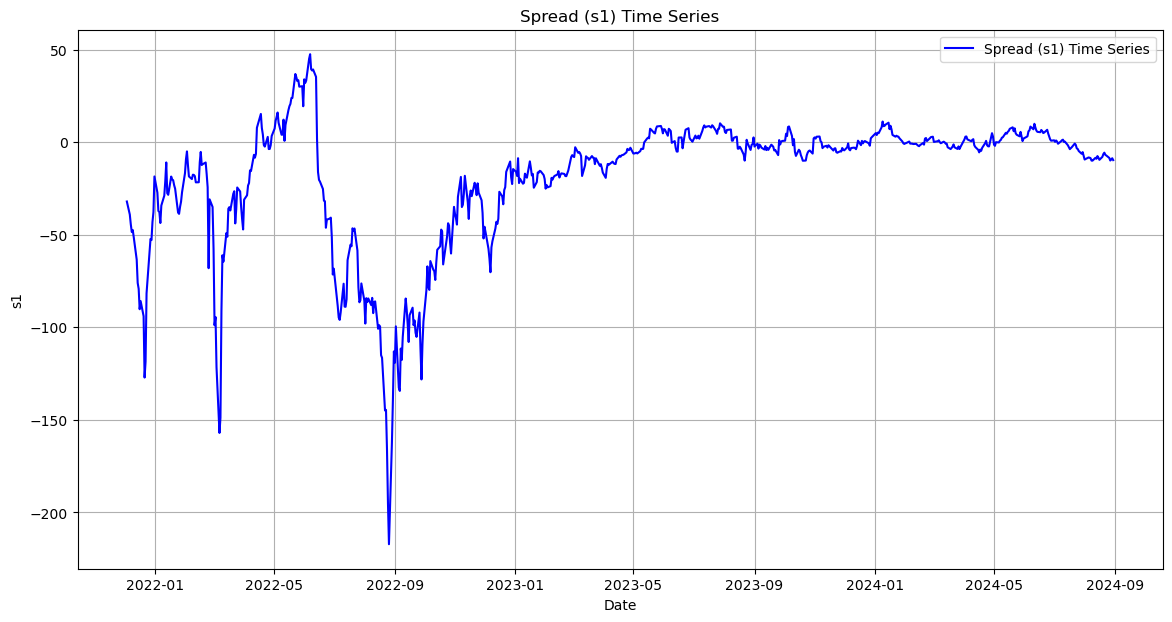

In [89]:
# Plots the time series of the given spread data.
def plot_spread_time_series(spread_df, spread_column='s1', spread_name='Spread Time Series', color='blue'):
    plt.figure(figsize=(14, 7))
    plt.plot(spread_df.index, spread_df[spread_column], label=f'{spread_name}', color=color)
    plt.title(f"{spread_name}")
    plt.xlabel("Date")
    plt.ylabel(f"{spread_column}")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_spread_time_series(df_pair1, spread_column='s1', spread_name='Spread (s1) Time Series', color='blue')

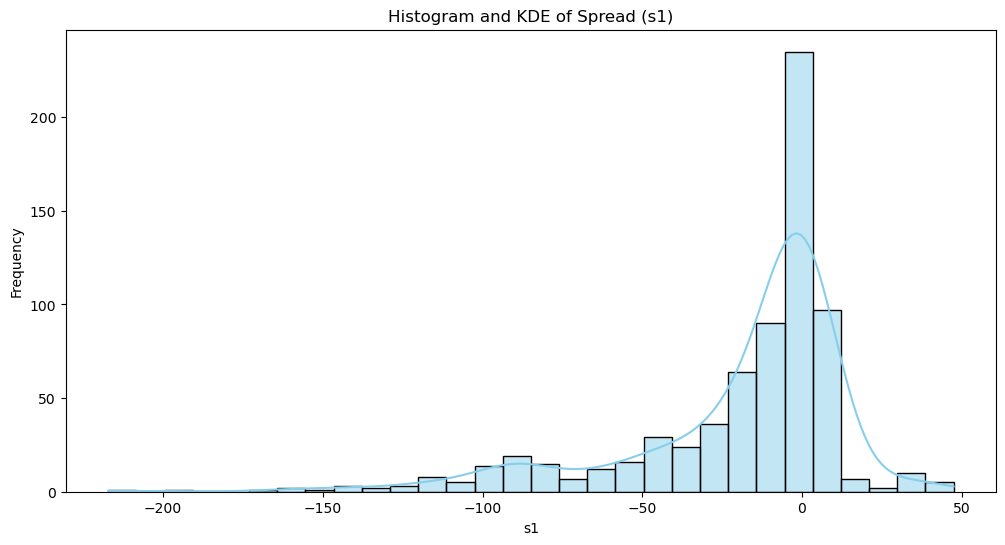

In [95]:
# Generates a histogram with KDE for the given spread data.
def plot_spread_histogram_kde(spread_df, spread_column='s1', spread_name='Spread (s1)', bins=30, color='skyblue'):
    plt.figure(figsize=(12, 6))
    sns.histplot(spread_df[spread_column], kde=True, bins=bins, color=color)
    plt.title(f"Histogram and KDE of {spread_name}")
    plt.xlabel(f"{spread_column}")
    plt.ylabel("Frequency")
    plt.show()
plot_spread_histogram_kde(df_pair1, spread_column='s1', spread_name='Spread (s1)', bins=30, color='skyblue')

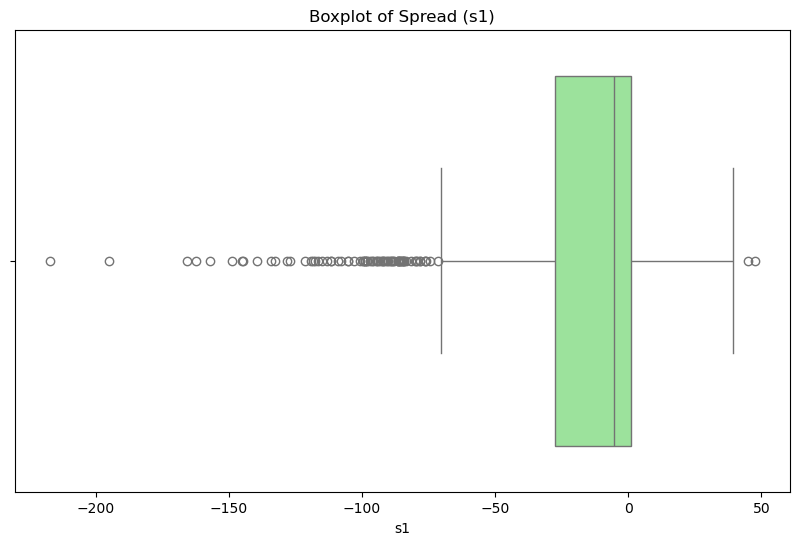

In [90]:
# Plots a boxplot of the given spread data.
def plot_spread_boxplot(spread_df, spread_column='s1', spread_name='Spread Boxplot', color='lightgreen'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=spread_df[spread_column], color=color)
    plt.title(f"Boxplot of {spread_name}")
    plt.xlabel(f"{spread_column}")
    plt.show()
plot_spread_boxplot(df_pair1, spread_column='s1', spread_name='Spread (s1)', color='lightgreen')

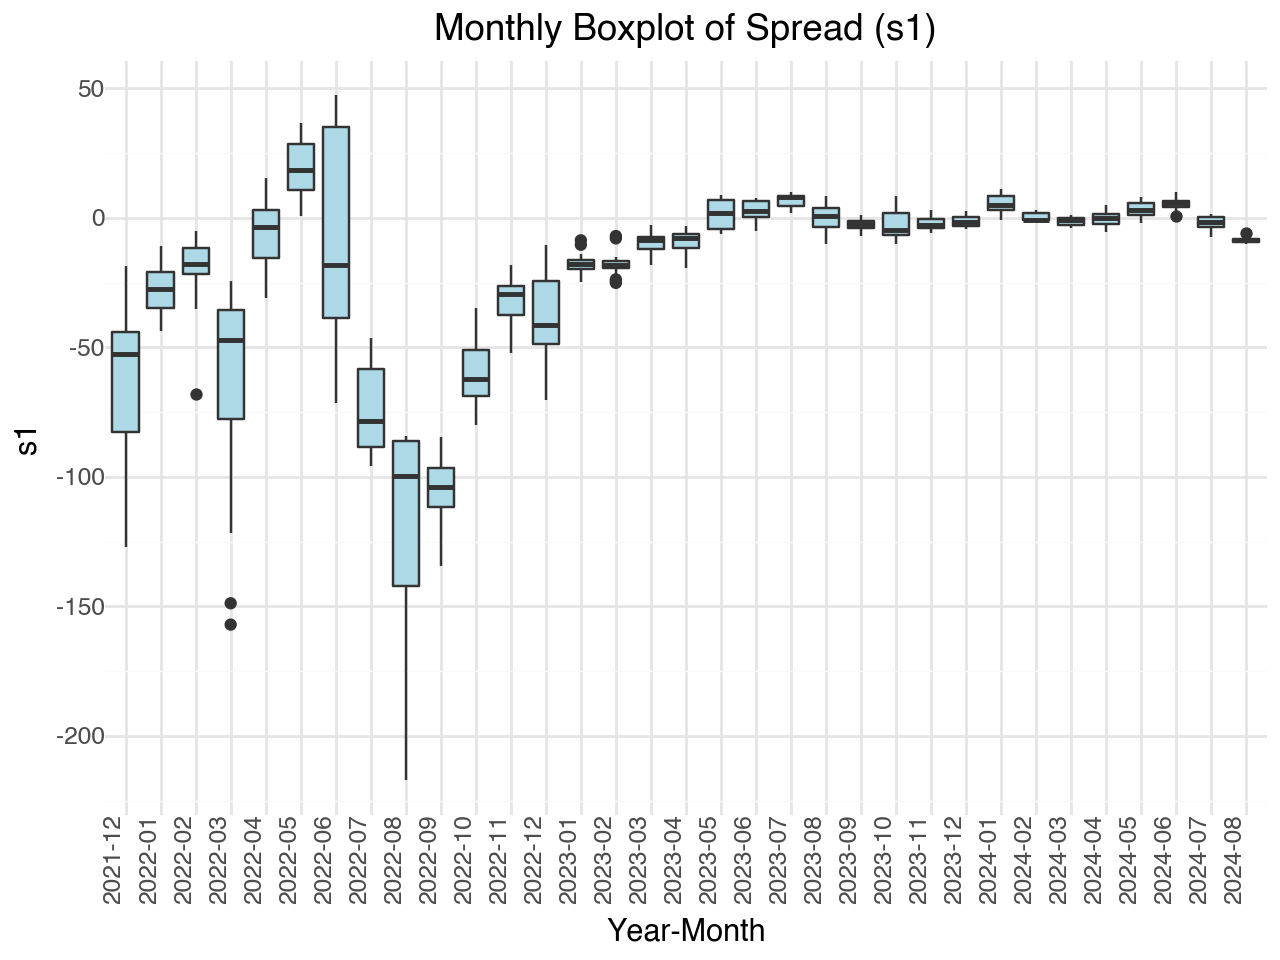

In [91]:
# Plots a monthly boxplot of the given spread data using plotnine.
def plot_monthly_boxplot(spread_df, date_column='date', spread_column='s1', spread_name='Spread (s1)'):
    spread_df = spread_df.reset_index()  # Reset index to access date column
    spread_df['YearMonth'] = spread_df[date_column].dt.to_period('M').astype(str)  # Extract Year-Month
    
    plot = (
        ggplot(spread_df, aes(x='YearMonth', y=spread_column))
        + geom_boxplot(fill='lightblue')
        + theme_minimal()
        + theme(axis_text_x=element_text(rotation=90, hjust=1))
        + labs(title=f'Monthly Boxplot of {spread_name}', x='Year-Month', y=spread_column)
    )
    
    spread_df.set_index(date_column, inplace=True)  # Restore original index
    return plot
p1_box = plot_monthly_boxplot(df_pair1, date_column='date', spread_column='s1', spread_name='Spread (s1)')
p1_box

In [92]:
# Computes and returns a DataFrame of quantiles, mean, median, standard deviation, skewness, and kurtosis of the spread.
def compute_spread_statistics(spread_df, spread_column='s1', spread_name='Spread (s1)'):
    stats_dict = {
        "Quantiles": spread_df[spread_column].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).values,
        "Statistic": ['1% Quantile', '5% Quantile', '25% Quantile', 'Median (50%)', '75% Quantile', '95% Quantile', '99% Quantile'],
    }
    summary_stats = {
        "Mean": spread_df[spread_column].mean(),
        "Median": spread_df[spread_column].median(),
        "Standard Deviation": spread_df[spread_column].std(),
        "Skewness": spread_df[spread_column].skew(),
        "Kurtosis": spread_df[spread_column].kurtosis(),
    }
    
    stats_df = pd.DataFrame(stats_dict)
    summary_df = pd.DataFrame(summary_stats.items(), columns=['Statistic', 'Value'])
    
    combined_df = pd.concat([stats_df, summary_df], ignore_index=True)
    return combined_df

In [93]:
spread_stats_df = compute_spread_statistics(df_pair1, spread_column='s1', spread_name='Spread (s1)')
spread_stats_df

,Quantiles,Statistic,Value
0,-144.209299,1% Quantile,NaN
1,-96.647042,5% Quantile,NaN
2,-27.610917,25% Quantile,NaN
3,-5.405373,Median (50%),NaN
4,1.209930,75% Quantile,NaN
5,8.811651,95% Quantile,NaN
6,34.981709,99% Quantile,NaN
7,NaN,Mean,-19.609786
8,NaN,Median,-5.405373
9,NaN,Standard Deviation,35.784674


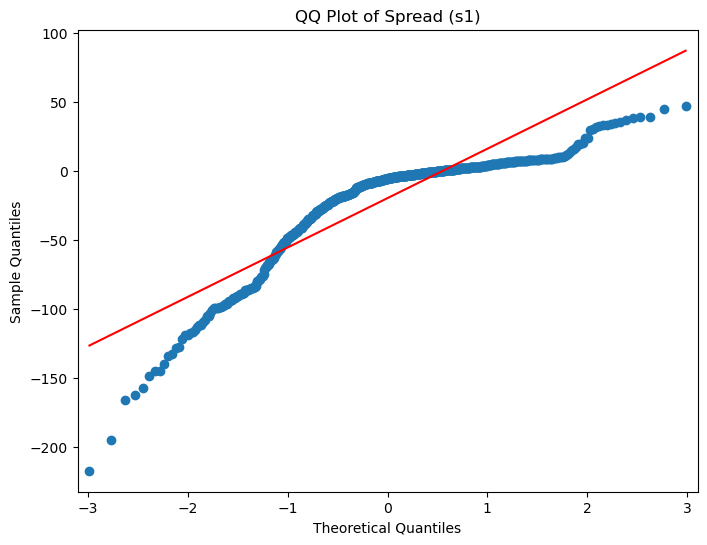

In [94]:
# Generates a QQ-plot for the given spread data.
def plot_spread_qqplot(spread_df, spread_column='s1', spread_name='Spread (s1)'):
    plt.figure(figsize=(8, 6))
    qqplot(spread_df[spread_column], line='s', ax=plt.gca())
    plt.title(f"QQ Plot of {spread_name}")
    plt.show()
plot_spread_qqplot(df_pair1, spread_column='s1', spread_name='Spread (s1)')

In [96]:
# Performs Kolmogorov-Smirnov test for normality on the given spread data.
def ks_test_for_normality(spread_df, spread_column='s1', spread_name='Spread (s1)', alpha=0.05):
    spread_standardized = (spread_df[spread_column] - spread_df[spread_column].mean()) / spread_df[spread_column].std()
    
    ks_stat, ks_pvalue = stats.kstest(spread_standardized, 'norm')
    print(f"\nKolmogorov-Smirnov Test for Normality - {spread_name}:")
    print(f"KS Statistic: {ks_stat:.4f}")
    print(f"p-value: {ks_pvalue:.4f}")
    
    if ks_pvalue < alpha:
        print("Reject the null hypothesis: The spread does not follow a normal distribution.")
    else:
        print("Fail to reject the null hypothesis: The spread may follow a normal distribution.")

ks_test_for_normality(df_pair1, spread_column='s1', spread_name='Spread (s1)', alpha=0.05)


Kolmogorov-Smirnov Test for Normality - Spread (s1):
KS Statistic: 0.2047
p-value: 0.0000
Reject the null hypothesis: The spread does not follow a normal distribution.


In [98]:
adf_s1 = ts.adfuller(df_pair1['s1'].dropna(), autolag='AIC')

def print_adf_results(adf_res, spread_name):
    print(f"\nADF Test for {spread_name}:")
    print(f"  ADF Statistic: {adf_res[0]}")
    print(f"  p-value:       {adf_res[1]}")
    for key, value in adf_res[4].items():
        print(f"     Critical Value ({key}): {value}")
        
print_adf_results(adf_s1, "s1")


ADF Test for s1:
  ADF Statistic: -3.127999055095128
  p-value:       0.02454933311630283
     Critical Value (1%): -3.4396861854831964
     Critical Value (5%): -2.865660062273053
     Critical Value (10%): -2.5689640195342456


In [100]:
# Fits Normal and Student's t-distribution to the data and computes log-likelihood, AIC, and BIC.
def fit_distributions_and_compare(spread_df, spread_column='s1'):
    data = spread_df[spread_column].dropna().values
    
    mu_normal, std_normal = np.mean(data), np.std(data, ddof=1)
    ll_normal = np.sum(stats.norm.logpdf(data, loc=mu_normal, scale=std_normal))
    aic_normal = 2 * 2 - 2 * ll_normal  # 2 parameters: mean and std
    bic_normal = np.log(len(data)) * 2 - 2 * ll_normal

    df_t, loc_t, scale_t = stats.t.fit(data)
    ll_t = np.sum(stats.t.logpdf(data, df_t, loc_t, scale_t))
    aic_t = 2 * 3 - 2 * ll_t  # 3 parameters: df, loc, scale
    bic_t = np.log(len(data)) * 3 - 2 * ll_t

    results = pd.DataFrame({
        'Distribution': ['Normal', "Student's t"],
        'Log-Likelihood': [ll_normal, ll_t],
        'AIC': [aic_normal, aic_t],
        'BIC': [bic_normal, bic_t]
    })

    print("\nDistribution Fit Summary:")
    return results
fit_summary = fit_distributions_and_compare(df_pair1, spread_column='s1')
print(fit_summary)


Distribution Fit Summary:
  Distribution  Log-Likelihood          AIC          BIC
0       Normal    -3541.988886  7087.977772  7097.105483
1  Student's t    -3371.846128  6749.692255  6763.383822


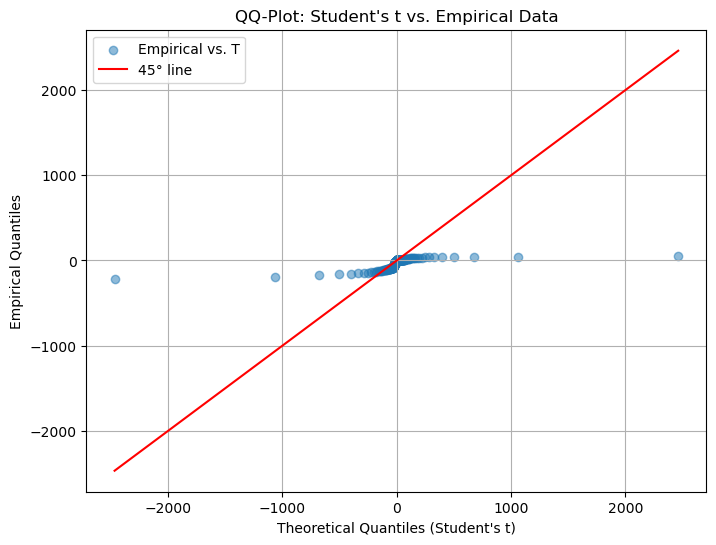

In [101]:
# Generates a QQ-plot comparing empirical data to theoretical quantiles of Student's t-distribution.
def plot_t_distribution_qqplot(spread_df, spread_column='s1'):
    data = spread_df[spread_column].dropna().values
    sorted_data = np.sort(data)

    # Fit Student's t-distribution
    df_t, loc_t, scale_t = stats.t.fit(data)
    
    # Compute theoretical quantiles
    quantiles = np.linspace(0.001, 0.999, len(data))
    theoretical_quantiles = stats.t.ppf(quantiles, df_t, loc_t, scale_t)

    # Plot QQ-Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(theoretical_quantiles, sorted_data, alpha=0.5, label="Empirical vs. T")
    
    # 45-degree reference line
    min_val = min(theoretical_quantiles[0], sorted_data[0])
    max_val = max(theoretical_quantiles[-1], sorted_data[-1])
    plt.plot([min_val, max_val], [min_val, max_val], color='r', label='45° line')

    plt.xlabel("Theoretical Quantiles (Student's t)")
    plt.ylabel("Empirical Quantiles")
    plt.title("QQ-Plot: Student's t vs. Empirical Data")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_t_distribution_qqplot(df_pair1, spread_column='s1')

Optimal KDE Bandwidth = 5.00


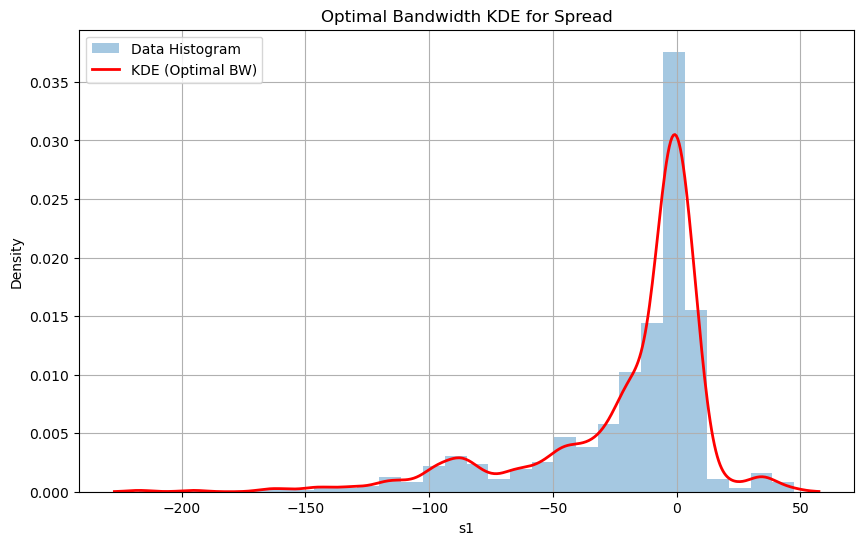

In [102]:
# Fits a KDE with optimal bandwidth and plots the density estimate along with the histogram.
def plot_optimal_kde(spread_df, spread_column='s1', bins=30):
    data = spread_df[spread_column].dropna().values
    data_reshaped = data.reshape(-1, 1)
    
    # Cross-validation for optimal bandwidth
    bandwidths = np.linspace(0.5, 5.0, 10)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=5)
    grid.fit(data_reshaped)
    
    best_bw = grid.best_params_['bandwidth']
    print(f"Optimal KDE Bandwidth = {best_bw:.2f}")
    
    # Fit KDE with optimal bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bw).fit(data_reshaped)
    
    # Generate KDE plot points
    x_grid = np.linspace(data.min() - 10, data.max() + 10, 500)
    log_dens = kde.score_samples(x_grid.reshape(-1, 1))
    pdf_kde = np.exp(log_dens)

    # Plot histogram and KDE
    plt.figure(figsize=(10, 6))
    plt.hist(data, density=True, alpha=0.4, bins=bins, label='Data Histogram')
    plt.plot(x_grid, pdf_kde, 'r-', lw=2, label='KDE (Optimal BW)')
    plt.title("Optimal Bandwidth KDE for Spread")
    plt.xlabel(f"{spread_column}")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_optimal_kde(df_pair1, spread_column='s1', bins=30)

In [104]:
# Performs bootstrap resampling and computes confidence intervals for the mean, skewness, and quantiles.
def bootstrap_confidence_intervals(spread_df, spread_column='s1', n_boot=1000, ci_percent=95):
    data = spread_df[spread_column].dropna().values
    n = len(data)
    boot_means = []
    boot_skews = []
    boot_q05 = []
    boot_q95 = []

    # Bootstrap resampling
    for _ in range(n_boot):
        sample = np.random.choice(data, size=n, replace=True)
        boot_means.append(np.mean(sample))
        boot_skews.append(stats.skew(sample))
        boot_q05.append(np.quantile(sample, 0.05))
        boot_q95.append(np.quantile(sample, 0.95))

    boot_means = np.array(boot_means)
    boot_skews = np.array(boot_skews)
    boot_q05 = np.array(boot_q05)
    boot_q95 = np.array(boot_q95)

    alpha = (100 - ci_percent) / 2
    lower = alpha
    upper = 100 - alpha

    # Confidence intervals
    mean_ci = (np.percentile(boot_means, lower), np.percentile(boot_means, upper))
    skew_ci = (np.percentile(boot_skews, lower), np.percentile(boot_skews, upper))
    q05_ci = (np.percentile(boot_q05, lower), np.percentile(boot_q05, upper))
    q95_ci = (np.percentile(boot_q95, lower), np.percentile(boot_q95, upper))

    print("\n--- Bootstrap Confidence Intervals ---")
    print(f"Mean {ci_percent}% CI: {mean_ci}")
    print(f"Skewness {ci_percent}% CI: {skew_ci}")
    print(f"5% Quantile {ci_percent}% CI: {q05_ci}")
    print(f"95% Quantile {ci_percent}% CI: {q95_ci}")

    return {
        'mean_ci': mean_ci,
        'skew_ci': skew_ci,
        'q05_ci': q05_ci,
        'q95_ci': q95_ci
    }
bootstrap_results = bootstrap_confidence_intervals(df_pair1, spread_column='s1', n_boot=1000, ci_percent=95)


--- Bootstrap Confidence Intervals ---
Mean 95% CI: (-22.427924121151165, -16.983966846778447)
Skewness 95% CI: (-2.112083637470165, -1.5150116437929726)
5% Quantile 95% CI: (-104.380605141, -89.72666700377181)
95% Quantile 95% CI: (8.229103117270599, 11.412691254688255)


In [107]:
# Fits a Generalized Pareto Distribution (GPD) to the negative tail of the spread data.
def fit_gpd_negative_tail(spread_df, spread_column='s1', percentile_threshold=5):
    data = spread_df[spread_column].dropna().values
    
    threshold = np.percentile(data, percentile_threshold)
    exceedances = data[data < threshold]  
    excess = -(exceedances - threshold)

    shape, loc, scale = genpareto.fit(excess, loc=0)
    
    print("--- GPD Fit (Negative Tail) ---")
    print(f"Threshold ({percentile_threshold}th Percentile): {threshold:.4f}")
    print(f"Shape: {shape:.4f}, Loc: {loc:.4f}, Scale: {scale:.4f}")
    
    ll_gpd = np.sum(genpareto.logpdf(excess, shape, loc=loc, scale=scale))
    aic_gpd = 2 * 2 - 2 * ll_gpd 
    
    print(f"GPD Log-Likelihood: {ll_gpd:.2f}")
    print(f"GPD AIC: {aic_gpd:.2f}")
    
    return {
        'threshold': threshold,
        'shape': shape,
        'loc': loc,
        'scale': scale,
        'log_likelihood': ll_gpd,
        'aic': aic_gpd
    }
gpd_results = fit_gpd_negative_tail(df_pair1, spread_column='s1', percentile_threshold=5)

--- GPD Fit (Negative Tail) ---
Threshold (5th Percentile): -96.6470
Shape: 0.0441, Loc: 0.2096, Scale: 25.9308
GPD Log-Likelihood: -154.78
GPD AIC: 313.57


In [108]:
# Computes the Value at Risk (VaR) and Expected Shortfall (ES) based on the GPD fit.
def gpd_var_es(prob, threshold, shape, scale):
    """
    Computes the Value at Risk (VaR) and Expected Shortfall (ES) at a given probability using GPD parameters.
    
    Parameters:
    - prob: Probability level (e.g., 0.95 for 95% confidence).
    - threshold: The threshold used for the tail (e.g., 5th percentile).
    - shape: Shape parameter of the GPD.
    - scale: Scale parameter of the GPD.

    Returns:
    - var: Value at Risk at the specified probability.
    - es: Expected Shortfall at the specified probability.
    """
    alpha = 1 - prob  =
    if shape != 0:
        var_excess = scale / shape * ((alpha) ** (-shape) - 1)
    else:
        var_excess = scale * np.log(1 / alpha)
    var = threshold - var_excess  # VaR

    # Expected Shortfall (ES)
    if shape < 1:
        es_excess = (var_excess / (1 - shape)) + scale - shape * threshold
        es = threshold - es_excess
    else:
        es = np.nan  =
    
    return var, es

var_95, es_95 = gpd_var_es(prob=0.95, threshold=gpd_results['threshold'], shape=gpd_results['shape'], scale=gpd_results['scale'])
print(f"95% VaR (negative tail) ~ {var_95:.2f}")
print(f"95% Expected Shortfall (negative tail) ~ {es_95:.2f}")


95% VaR (negative tail) ~ -179.70
95% Expected Shortfall (negative tail) ~ -213.73


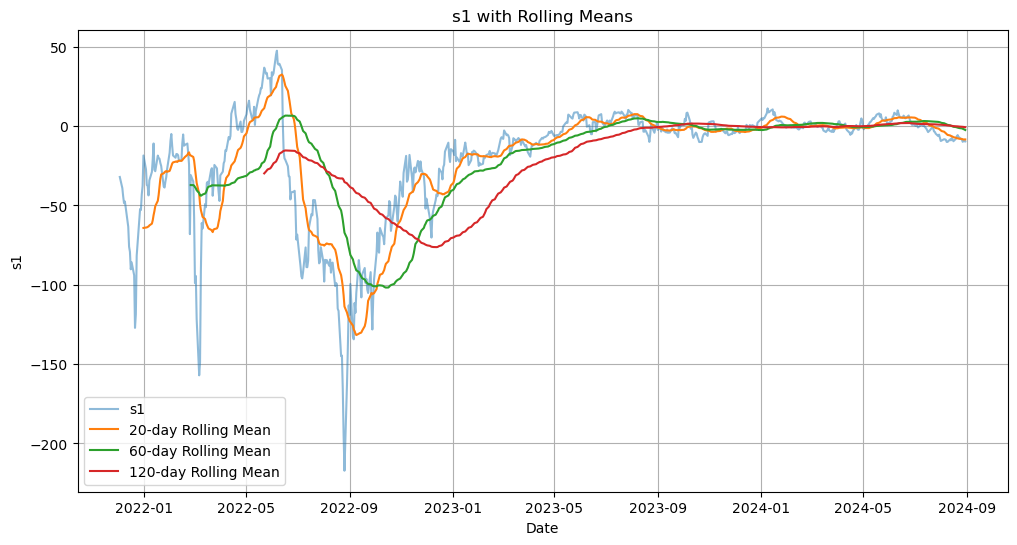

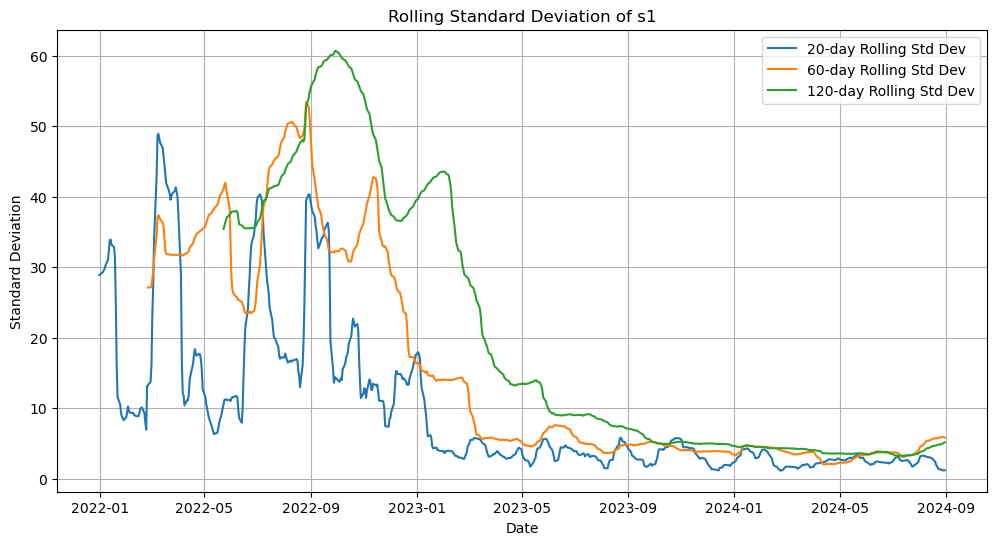

In [109]:
# Computes and plots rolling mean and standard deviation for specified window sizes.
def plot_rolling_statistics(spread_df, spread_column='s1', window_sizes=[20, 60, 120]):
    df = spread_df.copy()

    for w in window_sizes:
        df[f'roll_mean_{w}'] = df[spread_column].rolling(w).mean()
        df[f'roll_std_{w}'] = df[spread_column].rolling(w).std()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[spread_column], label=f'{spread_column}', alpha=0.5)
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_mean_{w}'], label=f'{w}-day Rolling Mean')
    plt.title(f"{spread_column} with Rolling Means")
    plt.xlabel("Date")
    plt.ylabel(f"{spread_column}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_std_{w}'], label=f'{w}-day Rolling Std Dev')
    plt.title(f"Rolling Standard Deviation of {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Standard Deviation")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_rolling_statistics(df_pair1, spread_column='s1', window_sizes=[20, 60, 120])

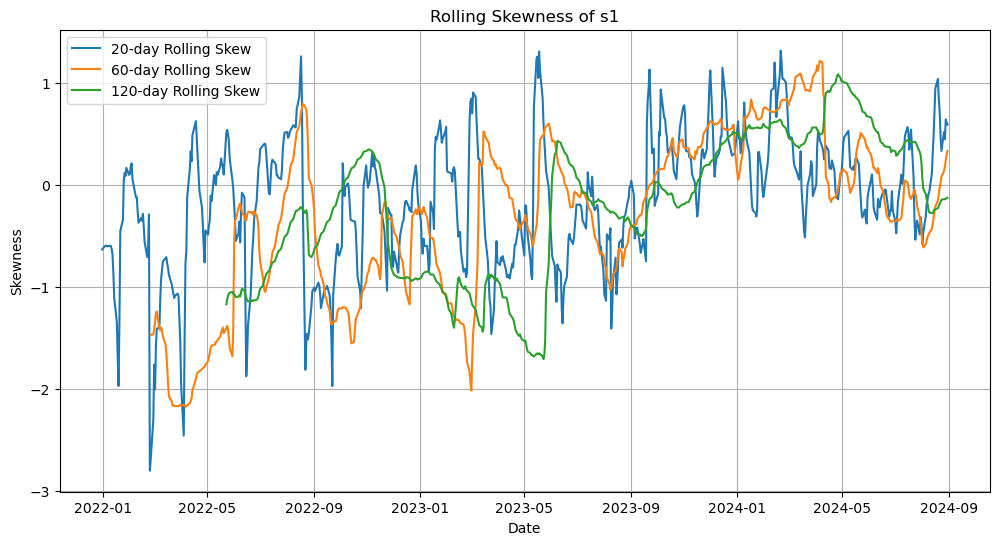

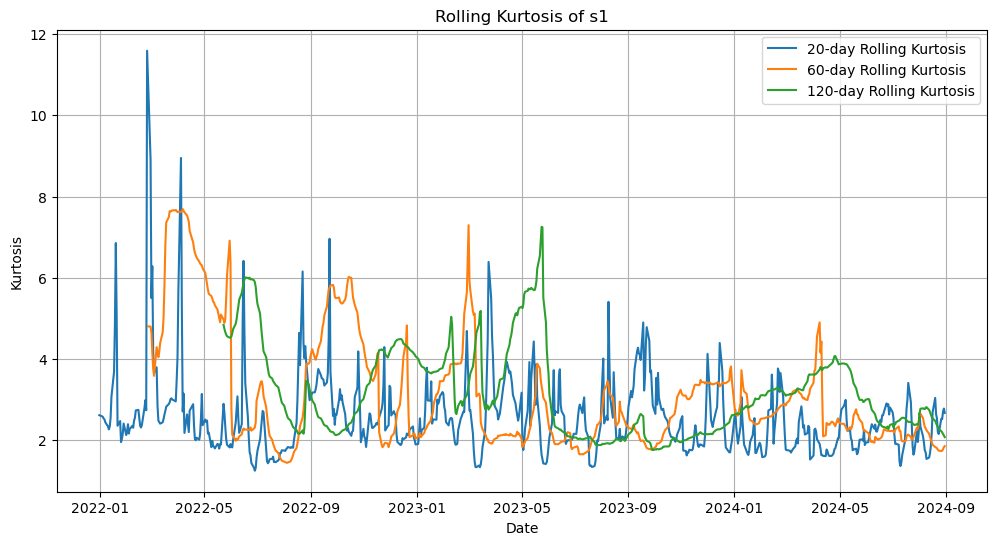

In [110]:
# Computes and plots rolling skewness and kurtosis for specified window sizes.
def plot_rolling_moments(spread_df, spread_column='s1', window_sizes=[20, 60, 120]):
    df = spread_df.copy()

    for w in window_sizes:
        df[f'roll_skew_{w}'] = df[spread_column].rolling(w).apply(lambda x: skew(x.dropna()), raw=False)
        df[f'roll_kurt_{w}'] = df[spread_column].rolling(w).apply(lambda x: kurtosis(x.dropna(), fisher=False), raw=False)

    plt.figure(figsize=(12, 6))
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_skew_{w}'], label=f'{w}-day Rolling Skew')
    plt.title(f"Rolling Skewness of {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Skewness")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_kurt_{w}'], label=f'{w}-day Rolling Kurtosis')
    plt.title(f"Rolling Kurtosis of {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Kurtosis")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_rolling_moments(df_pair1, spread_column='s1', window_sizes=[20, 60, 120])

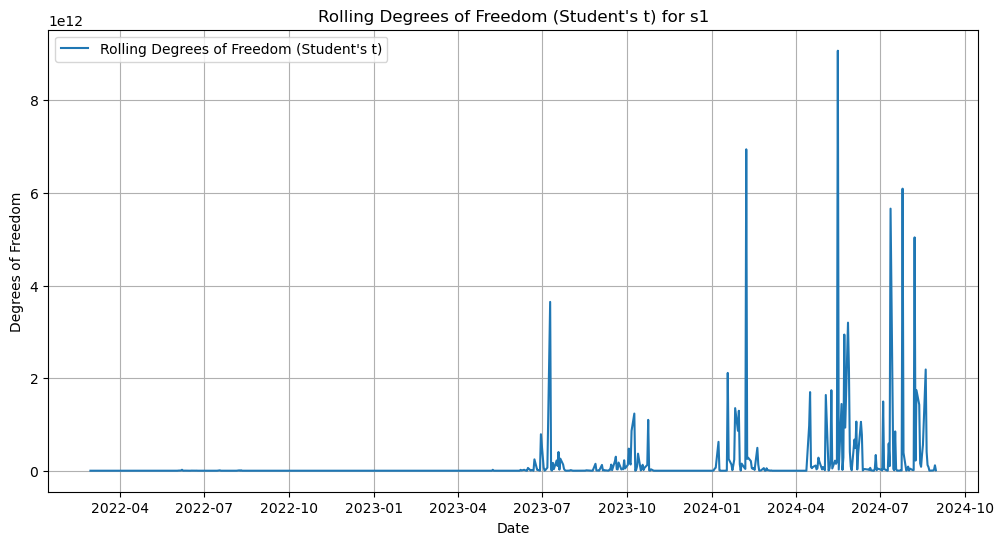

In [111]:
# Computes and plots the rolling fit of Student's t-distribution parameters.
def plot_rolling_student_t_fit(spread_df, spread_column='s1', window=60):
    df = spread_df.copy()
    df['df_t'] = np.nan
    df['loc_t'] = np.nan
    df['scale_t'] = np.nan

    for i in range(window, len(df)):
        sample = df[spread_column].iloc[i - window:i].dropna().values
        if len(sample) > 0:
            df_val, loc_val, scale_val = t.fit(sample)
            df.loc[df.index[i], 'df_t'] = df_val
            df.loc[df.index[i], 'loc_t'] = loc_val
            df.loc[df.index[i], 'scale_t'] = scale_val

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['df_t'], label='Rolling Degrees of Freedom (Student\'s t)', color='tab:blue')
    plt.title(f"Rolling Degrees of Freedom (Student's t) for {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Degrees of Freedom")
    plt.grid(True)
    plt.legend()
    plt.show()

    return df[['df_t', 'loc_t', 'scale_t']]
rolling_t_fit_df = plot_rolling_student_t_fit(df_pair1, spread_column='s1', window=60)

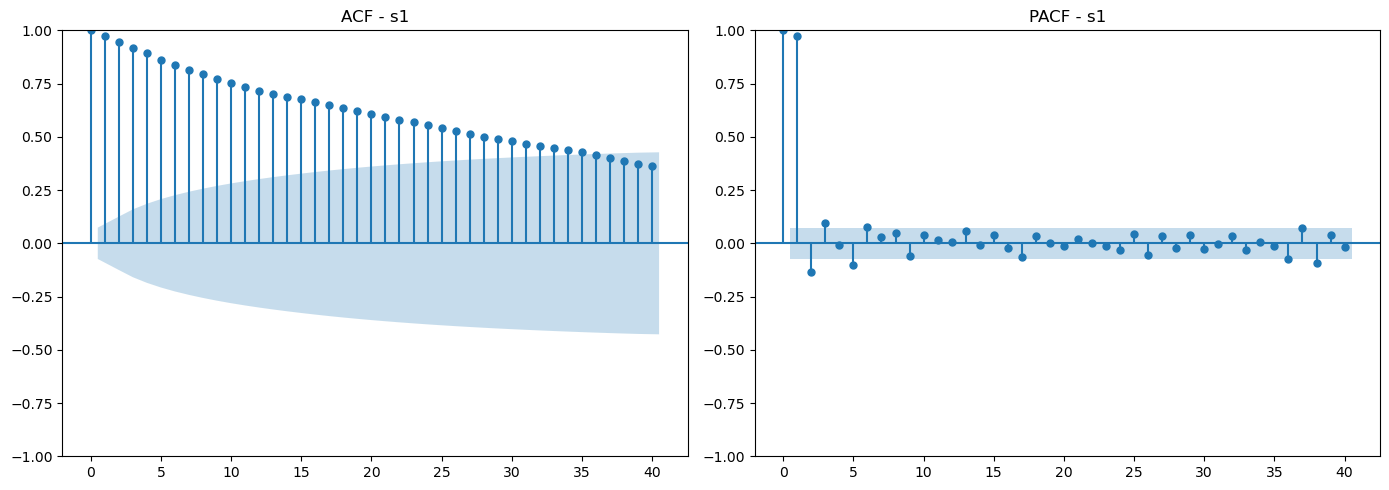

In [112]:
# Plots the ACF and PACF for the given spread data.
def plot_acf_pacf(spread_df, spread_column='s1', lags=40):
    df_spread = spread_df[[spread_column]].dropna()

    acf_vals = acf(df_spread[spread_column], nlags=lags, fft=False)
    pacf_vals = pacf(df_spread[spread_column], nlags=lags, method='ols')

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sm.graphics.tsa.plot_acf(df_spread[spread_column], lags=lags, ax=ax[0], title=f"ACF - {spread_column}")
    sm.graphics.tsa.plot_pacf(df_spread[spread_column], lags=lags, ax=ax[1], title=f"PACF - {spread_column}")
    plt.tight_layout()
    plt.show()
plot_acf_pacf(df_pair1, spread_column='s1', lags=40)

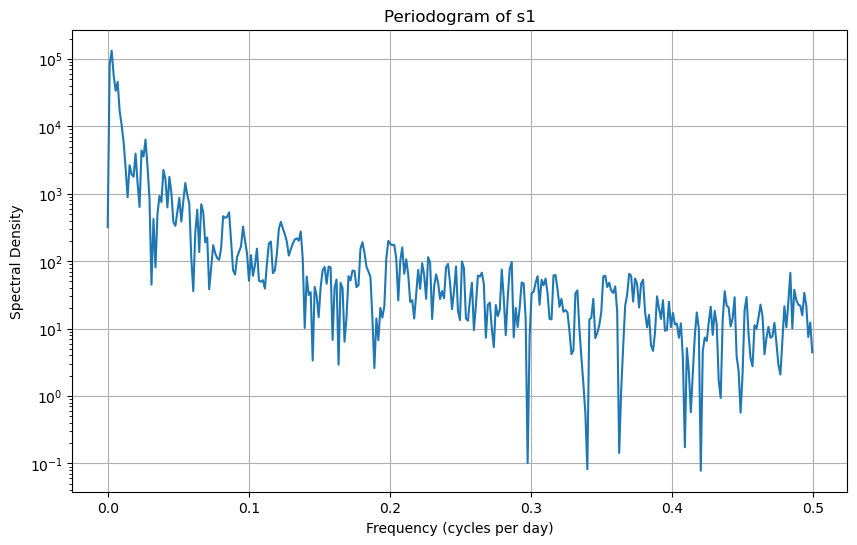

In [115]:
# Computes and plots the periodogram of the given spread data.
def plot_periodogram(spread_df, spread_column='s1', fs=1.0):
    data = spread_df[spread_column].dropna().values
    freqs, pxx = periodogram(data, fs=fs, window='hann', detrend='linear', scaling='density')
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs, pxx)  # Log scale for better visibility
    plt.title(f"Periodogram of {spread_column}")
    plt.xlabel("Frequency (cycles per day)")
    plt.ylabel("Spectral Density")
    plt.grid(True)
    plt.show()
plot_periodogram(df_pair1, spread_column='s1', fs=1.0)

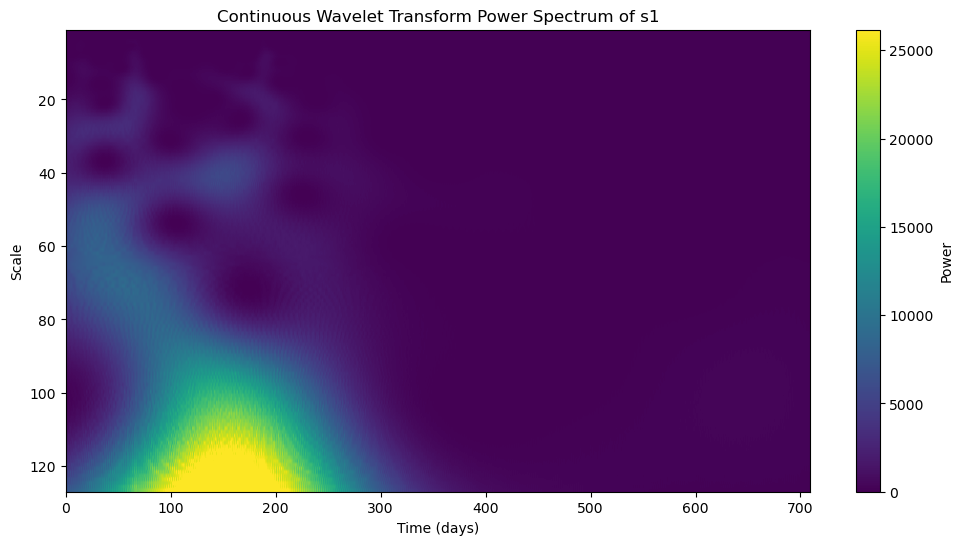

In [116]:
# Computes and plots the Continuous Wavelet Transform (CWT) power spectrum.
def plot_wavelet_power_spectrum(spread_df, spread_column='s1', wavelet='cmor1.5-1.0', scales=np.arange(1, 128), dt=1.0):
    data = spread_df[spread_column].dropna().values

    coeffs, freqs = pywt.cwt(data, scales, wavelet, dt)
    power = (np.abs(coeffs)) ** 2  

    plt.figure(figsize=(12, 6))
    plt.imshow(power, extent=[0, len(data) * dt, scales[-1], scales[0]], cmap='viridis', aspect='auto',
               vmax=np.percentile(power, 99))
    plt.colorbar(label='Power')
    plt.title(f"Continuous Wavelet Transform Power Spectrum of {spread_column}")
    plt.xlabel("Time (days)")
    plt.ylabel("Scale")
    plt.show()
plot_wavelet_power_spectrum(df_pair1, spread_column='s1', wavelet='cmor1.5-1.0', scales=np.arange(1, 128), dt=1.0)

Breakpoints (end of segments): [90, 145, 180, 220, 270, 709]


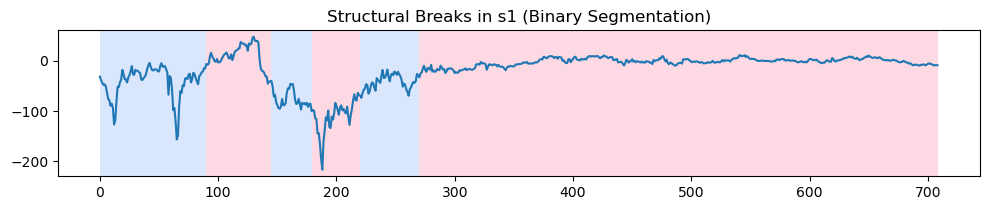

In [117]:
def detect_structural_breaks(spread_df, spread_column='s1', n_bkps=5, model_type='l2'):
    series = spread_df[spread_column].dropna().values
    algo = rpt.Binseg(model=model_type).fit(series)
    breakpoints = algo.predict(n_bkps=n_bkps)
    print("Breakpoints (end of segments):", breakpoints)
    rpt.display(series, breakpoints)
    plt.title(f"Structural Breaks in {spread_column} (Binary Segmentation)")
    plt.show()
    return breakpoints
    
breakpoints = detect_structural_breaks(df_pair1, spread_column='s1', n_bkps=5, model_type='l2')

Means of each state: [[0.02672308]
 [0.03838996]]
Variances of each state: [[[  4.46475217]]

 [[148.30994725]]]


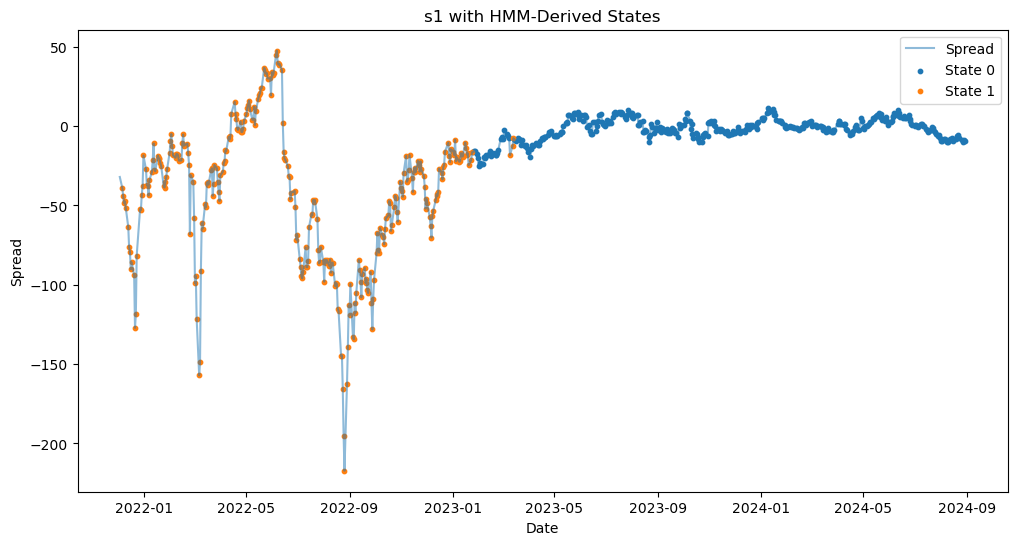

In [118]:
# Fits a Gaussian HMM to the spread returns and plots the inferred states.
def plot_hmm_states(spread_df, spread_column='s1', num_states=2, n_iter=100, random_state=42):
    df = spread_df.copy()
    returns = df[spread_column].diff().dropna().values.reshape(-1, 1)

    model = GaussianHMM(n_components=num_states, covariance_type="full", n_iter=n_iter, random_state=random_state)
    model.fit(returns)

    states = model.predict(returns)
    df.loc[df.index[1:], 'HMM_State'] = states  # Aligning state labels with the index

    print("Means of each state:", model.means_)
    print("Variances of each state:", model.covars_)

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[spread_column], alpha=0.5, label='Spread')
    for i in range(num_states):
        mask = (df['HMM_State'] == i)
        plt.scatter(df.index[mask], df[spread_column][mask], label=f"State {i}", s=10)
    plt.title(f"{spread_column} with HMM-Derived States")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.show()
    return model, states
model, states = plot_hmm_states(df_pair1, spread_column='s1', num_states=2, n_iter=100)

                               SARIMAX Results                                
Dep. Variable:                     s1   No. Observations:                  709
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2470.995
Date:                Wed, 15 Jan 2025   AIC                           4949.990
Time:                        10:59:52   BIC                           4968.245
Sample:                             0   HQIC                          4957.043
                                - 709                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.6101     14.534     -1.349      0.177     -48.096       8.876
ar.L1          0.9657      0.006    158.621      0.000       0.954       0.978
ma.L1          0.1632      0.018      9.128      0.0

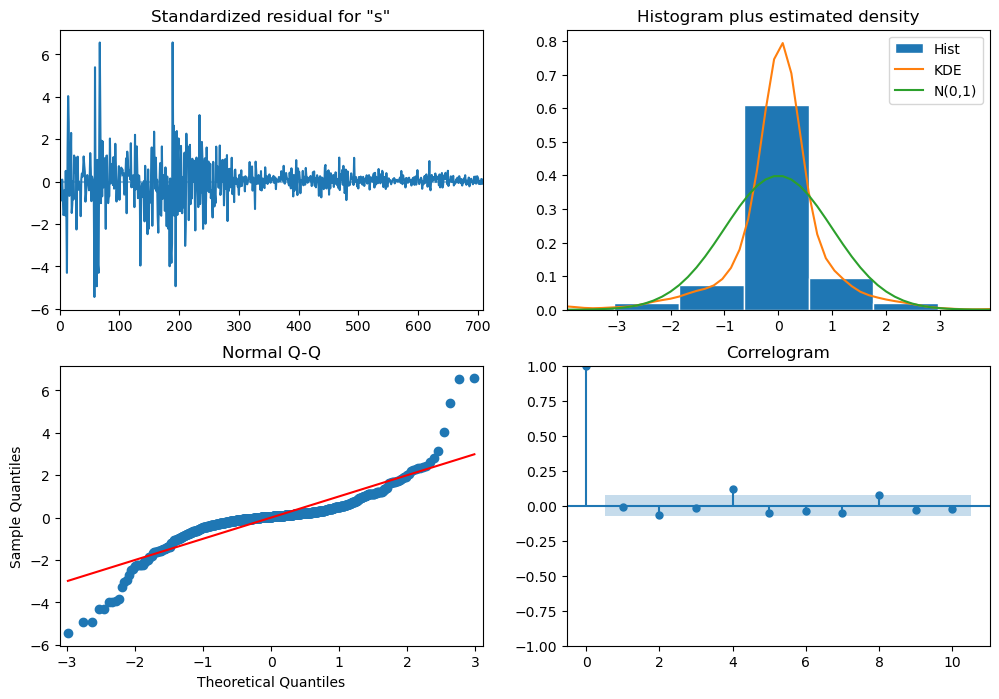

In [119]:
# Fits an ARIMA model to the spread time series and prints the summary.
def fit_arima_model(spread_df, spread_column='s1', order=(1, 0, 1)):

    s1_series = spread_df[spread_column].dropna()
    model = ARIMA(s1_series, order=order)
    results = model.fit()
    print(results.summary())
    results.plot_diagnostics(figsize=(12, 8))
    plt.show()
    return results
arima_results = fit_arima_model(df_pair1, spread_column='s1', order=(1, 0, 1))

Iteration:      5,   Func. Count:     31,   Neg. LLF: 2299.4153866992747
Iteration:     10,   Func. Count:     58,   Neg. LLF: 2001.794160916745
Iteration:     15,   Func. Count:     82,   Neg. LLF: 2001.7814338405751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2001.7814338405756
            Iterations: 15
            Function evaluations: 82
            Gradient evaluations: 15
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -2001.78
Distribution:      Standardized Student's t   AIC:                           4011.56
Method:                  Maximum Likelihood   BIC:                           4029.82
                                              No. Observations

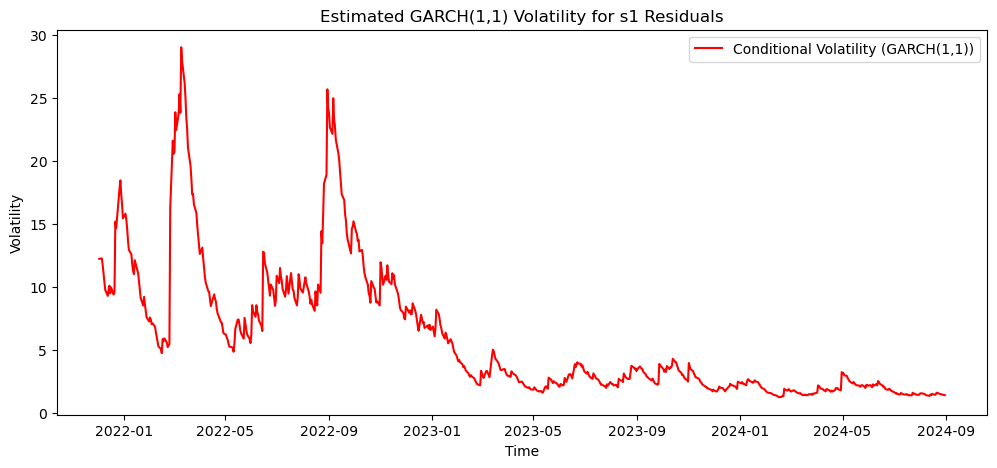

In [120]:
# Fits a GARCH(1,1) model to the residuals and plots the conditional volatility.
def fit_garch_model(spread_df, spread_column='s1', arima_results=None, p=1, q=1, mean='Zero', vol='GARCH', dist='t'):

    s1_series = spread_df[spread_column].dropna()
    resid_for_garch = arima_results.resid if arima_results else s1_series
    garch_model = arch_model(resid_for_garch, p=p, q=q, mean=mean, vol=vol, dist=dist)
    garch_res = garch_model.fit(update_freq=5)
    print(garch_res.summary())
    
    cond_vol = garch_res.conditional_volatility
    plt.figure(figsize=(12, 5))
    plt.plot(cond_vol, color='red', label=f'Conditional Volatility (GARCH({p},{q}))')
    plt.title(f"Estimated GARCH({p},{q}) Volatility for {spread_column} Residuals")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()
    return garch_res
garch_results = fit_garch_model(df_pair1, spread_column='s1', arima_results=arima_results, p=1, q=1)

### Pair 2: 7. CBT.TU versus CBT.US × 0.7894

In [49]:
# Y instrument: CBT.TU
df_Y = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'TU')]
df_Y_second = select_second_month(df_Y)
df_Y_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,2021-12-03,CBT,TU,TU,1M,109.242188,0.016468,-0.004078,-0.004768,0.000669,...,-0.850216,50.903726,29386.933092,5.827710e+05,-4.109265e+08,-2.431571e+10,-0.012035,0.006634,31.0,31.0
1,2021-12-06,CBT,TU,TU,1M,109.150000,0.016263,-0.005552,-0.004772,0.000832,...,-1.154042,60.283215,39043.700180,7.891772e+05,-4.662192e+08,-2.611277e+10,-0.012525,0.006625,31.0,31.0
2,2021-12-07,CBT,TU,TU,1M,109.040625,0.016424,-0.004993,-0.003925,0.001013,...,-0.922880,78.118617,23977.412496,-7.921378e+04,-2.089281e+08,-7.607722e+09,-0.011808,0.007551,31.0,31.0
3,2021-12-08,CBT,TU,TU,1M,109.065625,0.015349,-0.003759,-0.003169,0.001162,...,-0.831807,126.436080,35311.877661,-1.394790e+06,-5.537103e+08,-2.056880e+10,-0.009903,0.006238,31.0,31.0
4,2021-12-09,CBT,TU,TU,1M,109.039062,0.015355,-0.003979,-0.001998,0.000823,...,-0.903386,88.575862,36291.880019,-7.480978e+05,-4.461545e+08,-1.056958e+10,-0.008687,0.006601,31.0,31.0


In [50]:
# Z instrument: CBT.US
df_Z = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'US')]
df_Z_second = select_second_month(df_Z)
df_Z_second = df_Z_second.copy()
df_Z_second['futures_adj'] = df_Z_second['futures'] * 0.7894
df_Z_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination,futures_adj
0,2021-12-03,CBT,US,US,1M,162.709821,0.107847,0.007096,0.018796,0.003367,...,6.724124,13.286012,-281.719028,-2317.172013,25987.918900,-0.071269,0.098269,31.0,31.0,128.443133
1,2021-12-06,CBT,US,US,1M,161.140453,0.103458,0.001134,0.007704,0.002821,...,6.565345,48.714279,-480.779410,-6268.082671,64819.069390,-0.069529,0.085734,31.0,31.0,127.204274
2,2021-12-07,CBT,US,US,1M,160.203640,0.096955,0.000365,0.004507,0.002190,...,5.612642,39.577981,280.500722,-5139.060144,-19408.259457,-0.066813,0.083370,31.0,31.0,126.464754
3,2021-12-08,CBT,US,US,1M,159.132898,0.092402,-0.000578,0.002729,0.001940,...,5.469011,54.549282,434.971127,-8477.950753,-15427.808922,-0.065051,0.077948,31.0,31.0,125.619510
4,2021-12-09,CBT,US,US,1M,159.624657,0.093742,-0.002043,0.000406,0.002458,...,6.989844,64.648622,-334.945390,-8916.140117,69667.097312,-0.065556,0.081113,31.0,31.0,126.007704


In [51]:
df_pair2 = pd.merge(
    df_Y_second[['date', 'futures']],
    df_Z_second[['date', 'futures_adj']],
    on='date',
    how='inner'
)
df_pair2.rename(columns={'futures': 'Y', 'futures_adj': 'Z'}, inplace=True)
df_pair2.head()

,date,Y,Z
0,2021-12-03,109.242188,128.443133
1,2021-12-06,109.150000,127.204274
2,2021-12-07,109.040625,126.464754
3,2021-12-08,109.065625,125.619510
4,2021-12-09,109.039062,126.007704


In [52]:
df_pair2['s2'] = df_pair2['Z'] - df_pair2['Y']
df_pair2.head()

,date,Y,Z,s2
0,2021-12-03,109.242188,128.443133,19.200946
1,2021-12-06,109.150000,127.204274,18.054274
2,2021-12-07,109.040625,126.464754,17.424129
3,2021-12-08,109.065625,125.619510,16.553885
4,2021-12-09,109.039062,126.007704,16.968641


In [53]:
df_pair2.set_index('date', inplace=True)
df_pair2.sort_index(inplace=True)

In [54]:
print("\nData Information:")
print(df_pair2.info())
print("\nMissing Values:")
print(df_pair2.isnull().sum())
print(f"\n Duplicated Dates: {df_pair2.index.duplicated().sum()}")


Data Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 2021-12-03 to 2024-08-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       715 non-null    float64
 1   Z       715 non-null    float64
 2   s2      715 non-null    float64
dtypes: float64(3)
memory usage: 22.3 KB
None

Missing Values:
Y     0
Z     0
s2    0
dtype: int64

 Duplicated Dates: 0


In [55]:
# Descriptive statistics for the spread (s2)
print("\nDescriptive Statistics of Spread (s2):")
print(df_pair2['s2'].describe())


Descriptive Statistics of Spread (s2):
count    715.000000
mean      -1.329414
std        7.983488
min      -15.825837
25%       -7.614160
50%       -2.363162
75%        2.855279
max       19.200946
Name: s2, dtype: float64


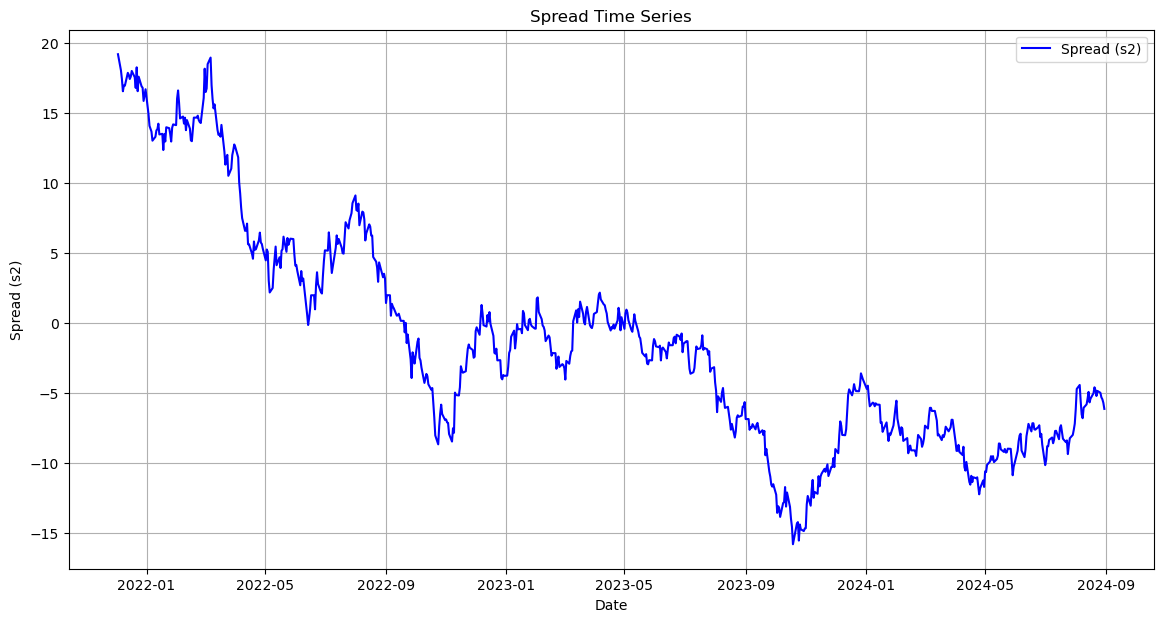

In [56]:
# Time Series Plot of Spread
plt.figure(figsize=(14, 7))
plt.plot(df_pair2.index, df_pair2['s2'], label='Spread (s2)', color='blue')
plt.title("Spread Time Series")
plt.xlabel("Date")
plt.ylabel("Spread (s2)")
plt.legend()
plt.grid(True)
plt.show()

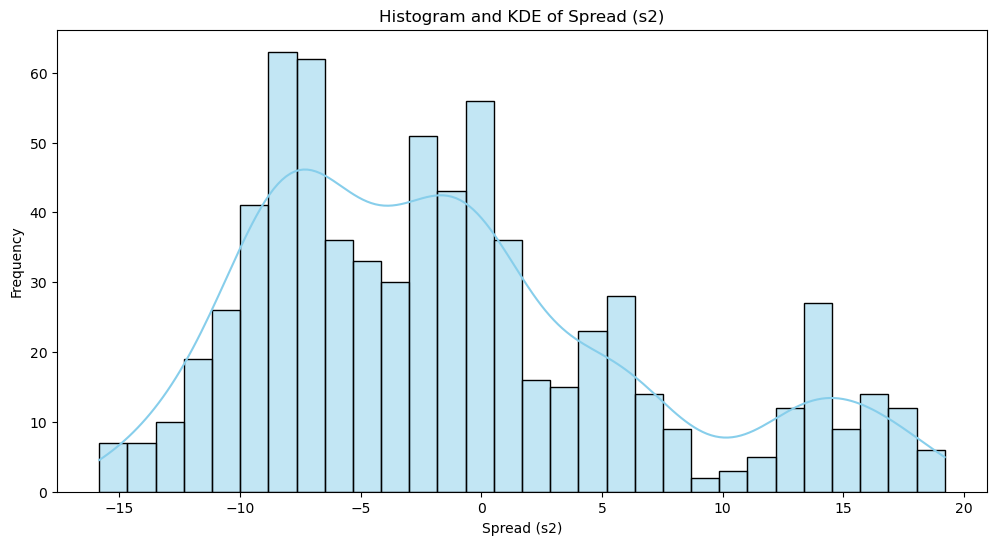

In [57]:
# Histogram with KDE
plt.figure(figsize=(12, 6))
sns.histplot(df_pair2['s2'], kde=True, bins=30, color='skyblue')
plt.title("Histogram and KDE of Spread (s2)")
plt.xlabel("Spread (s2)")
plt.ylabel("Frequency")
plt.show()

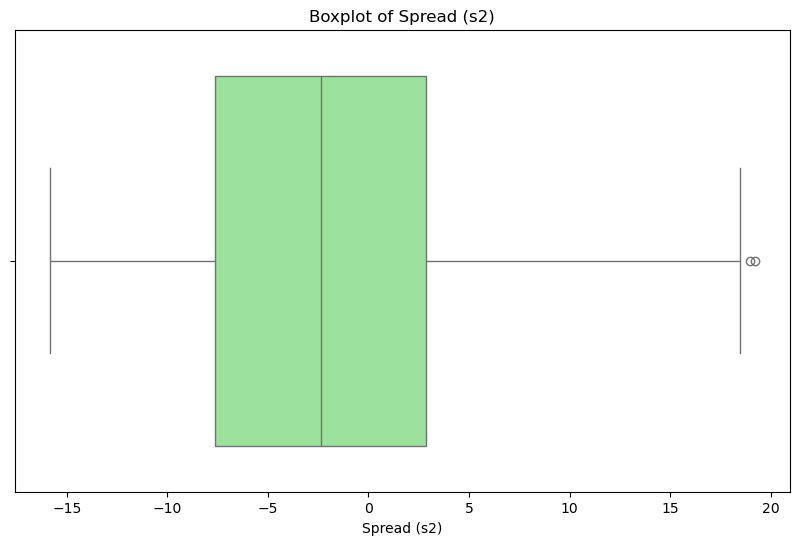

In [58]:
# Boxplot of Spread
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_pair2['s2'], color='lightgreen')
plt.title("Boxplot of Spread (s2)")
plt.xlabel("Spread (s2)")
plt.show()

In [59]:
# Skewness and Kurtosis
spread_skewness = df_pair2['s2'].skew()
spread_kurtosis = df_pair2['s2'].kurtosis()

print(f"\nSkewness of Spread (s2): {spread_skewness:.4f}")
print(f"Kurtosis of Spread (s2): {spread_kurtosis:.4f}")


Skewness of Spread (s2): 0.7565
Kurtosis of Spread (s2): -0.1271


In [60]:
# Quantiles
quantiles = df_pair2['s2'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("\nQuantiles of Spread (s2):")
print(quantiles)


Quantiles of Spread (s2):
0.01   -14.564192
0.05   -11.585995
0.25    -7.614160
0.50    -2.363162
0.75     2.855279
0.95    14.765371
0.99    17.849275
Name: s2, dtype: float64


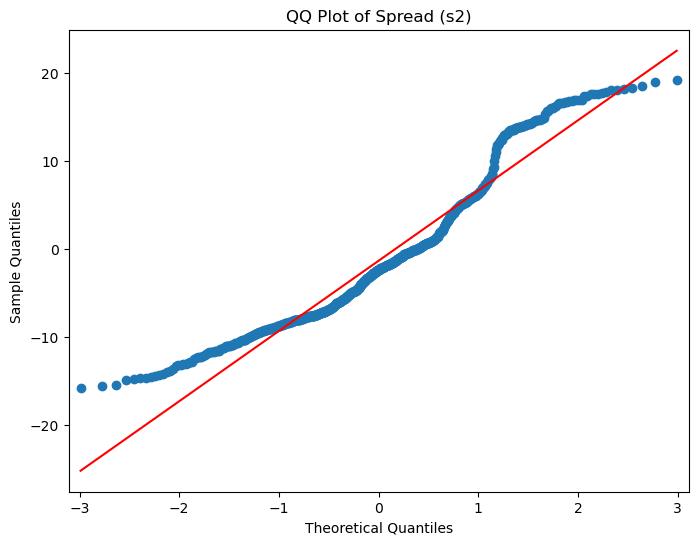

In [61]:
# QQ-Plot for Spread
plt.figure(figsize=(8, 6))
qqplot(df_pair2['s2'], line='s', ax=plt.gca())
plt.title("QQ Plot of Spread (s2)")
plt.show()

In [62]:
spread_standardized = (df_pair2['s2'] - df_pair2['s2'].mean()) / df_pair2['s2'].std()

ks_stat, ks_pvalue = stats.kstest(spread_standardized, 'norm')
print(f"\nKolmogorov-Smirnov Test for Normality:")
print(f"KS Statistic: {ks_stat:.4f}")
print(f"p-value: {ks_pvalue:.4f}")

alpha = 0.05
if ks_pvalue < alpha:
    print("Reject the null hypothesis: The spread does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis: The spread may follow a normal distribution.")


Kolmogorov-Smirnov Test for Normality:
KS Statistic: 0.0968
p-value: 0.0000
Reject the null hypothesis: The spread does not follow a normal distribution.


In [63]:
df_pair2['s2_zscore'] = (df_pair2['s2'] - df_pair2['s2'].mean()) / df_pair2['s2'].std(ddof=0)
df_pair2['s2_zscore'].describe()

count    7.150000e+02
mean     7.950129e-17
std      1.000700e+00
min     -1.817072e+00
25%     -7.877691e-01
50%     -1.295764e-01
75%      5.245355e-01
max      2.573403e+00
Name: s2_zscore, dtype: float64

In [64]:
outliers_s2 = df_pair2[np.abs(df_pair2['s2_zscore']) > 3]
print(outliers_s2[["Y", "Z", "s2", "s2_zscore"]])
print(f"Number of outliers in s1 (Z-score>3): {len(outliers_s1)}")

Empty DataFrame
Columns: [Y, Z, s2, s2_zscore]
Index: []
Number of outliers in s1 (Z-score>3): 13


In [65]:
adf_s2 = ts.adfuller(df_pair2['s2'].dropna(), autolag='AIC')
print_adf_results(adf_s2, "s2")


ADF Test for s2:
  ADF Statistic: -2.510090958546446
  p-value:       0.11303835147424413
     Critical Value (1%): -3.4395418285955563
     Critical Value (5%): -2.865596454500293
     Critical Value (10%): -2.5689301318958955


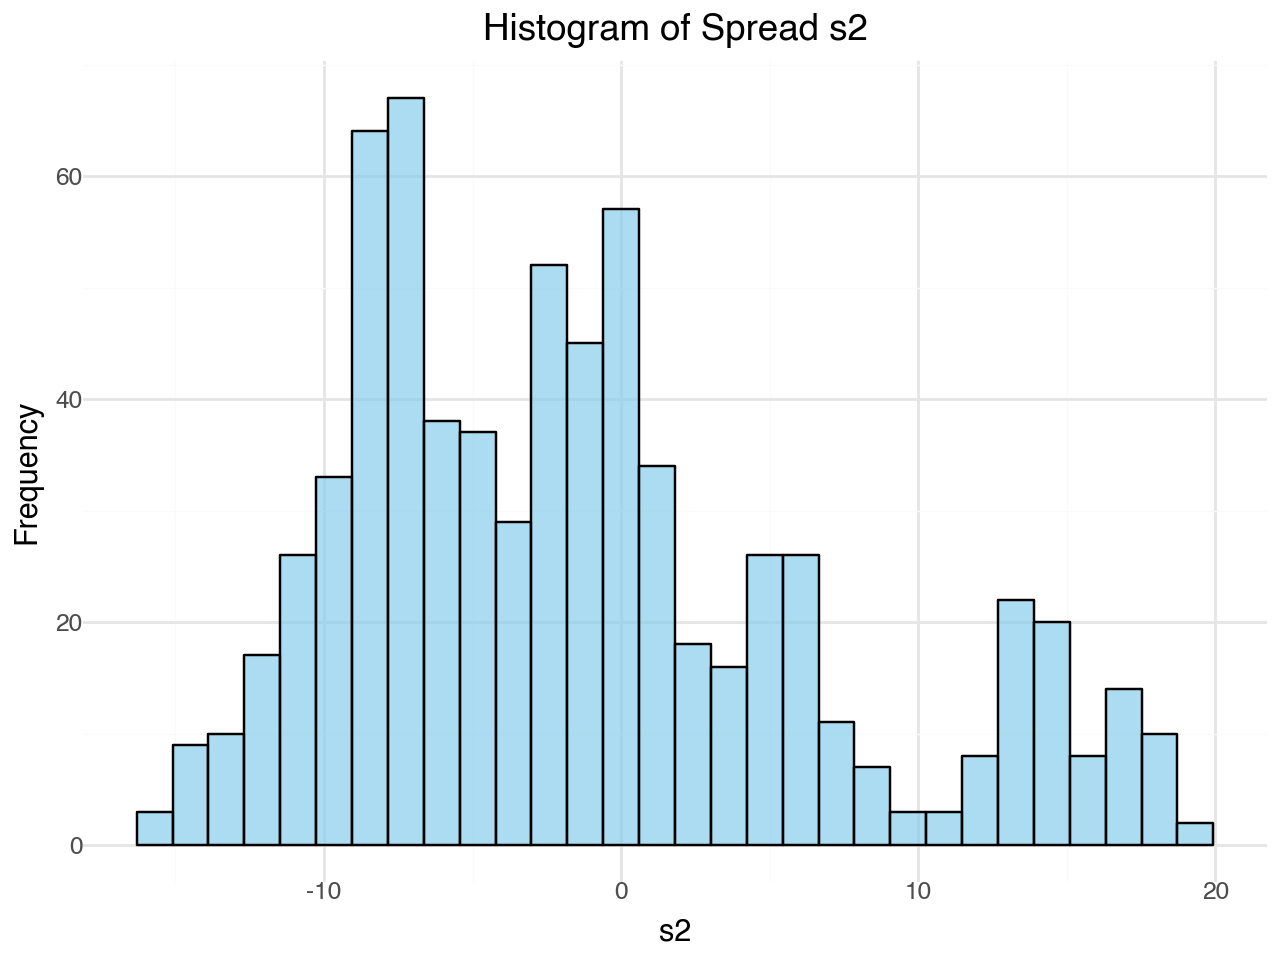

In [66]:
p2_hist = (
    ggplot(df_pair2, aes(x='s2'))
    + geom_histogram(bins=30, fill='skyblue', color='black', alpha=0.7)
    + labs(title='Histogram of Spread s2', x='s2', y='Frequency')
    + theme_minimal()
)
p2_hist

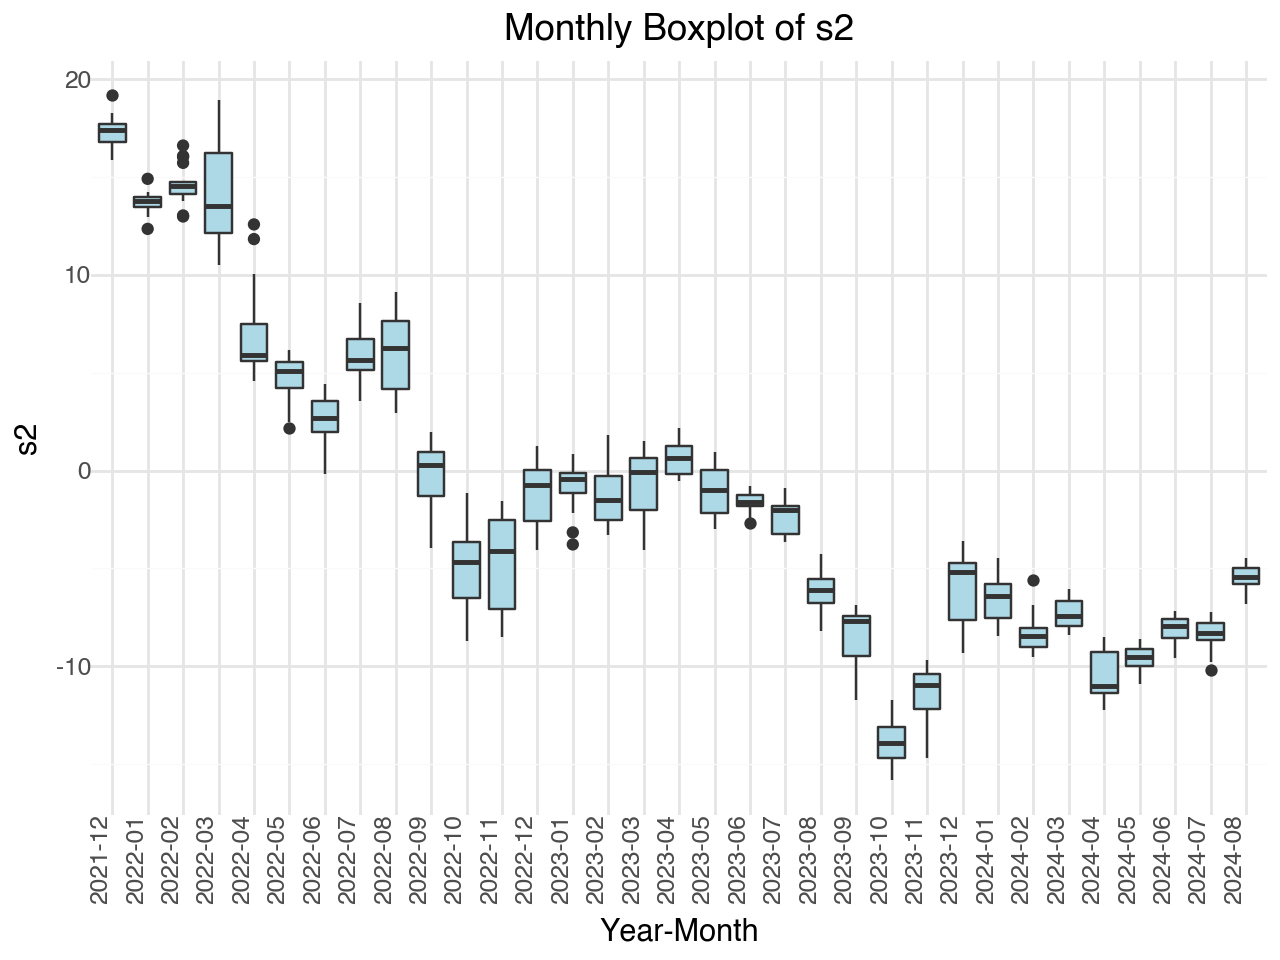

In [67]:
df_pair2.reset_index(inplace=True)
df_pair2['YearMonth'] = df_pair2['date'].dt.to_period('M').astype(str)
p2_box = (
    ggplot(df_pair2, aes(x='YearMonth', y='s2'))
    + geom_boxplot(fill='lightblue')
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
    + labs(title='Monthly Boxplot of s2', x='Year-Month', y='s2')
)
df_pair2.set_index("date", inplace=True)
p2_box

In [68]:
data = df_pair2['s2'].dropna().values 
mu_normal, std_normal = np.mean(data), np.std(data, ddof=1)
ll_normal = np.sum(stats.norm.logpdf(data, loc=mu_normal, scale=std_normal))
aic_normal = 2*2 - 2*ll_normal  
bic_normal = np.log(len(data))*2 - 2*ll_normal

df_t, loc_t, scale_t = stats.t.fit(data)
ll_t = np.sum(stats.t.logpdf(data, df_t, loc_t, scale_t))
aic_t = 2*3 - 2*ll_t
bic_t = np.log(len(data))*3 - 2*ll_t

results = pd.DataFrame({
    'Distribution': ['Normal', "Student's t"],
    'Log-Likelihood': [ll_normal, ll_t],
    'AIC': [aic_normal, aic_t],
    'BIC': [bic_normal, bic_t]
})

print("\nDistribution Fit Summary:")
print(results)


Distribution Fit Summary:
  Distribution  Log-Likelihood          AIC          BIC
0       Normal    -2499.364487  5002.728973  5011.873538
1  Student's t    -2499.364137  5004.728273  5018.445121


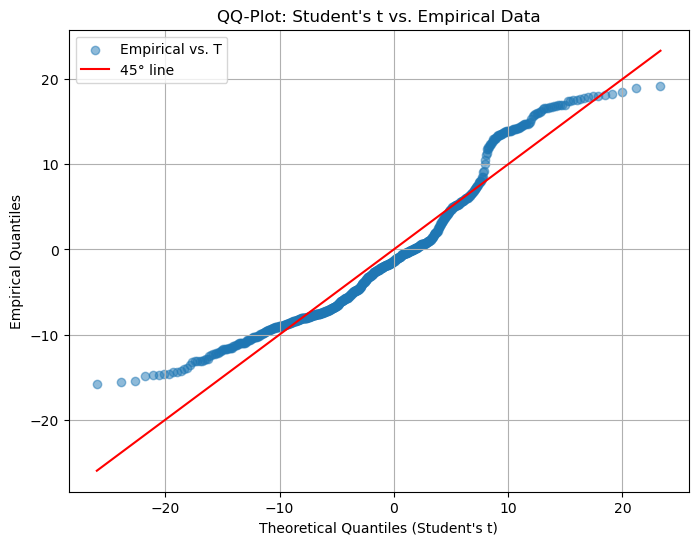

In [69]:
sorted_data = np.sort(data)
quantiles = np.linspace(0.001, 0.999, len(data)) 
theoretical_quantiles = stats.t.ppf(quantiles, df_t, loc_t, scale_t)

plt.figure(figsize=(8,6))
plt.scatter(theoretical_quantiles, sorted_data, alpha=0.5, label="Empirical vs. T")
# 45 degree line
min_val = min(theoretical_quantiles[0], sorted_data[0])
max_val = max(theoretical_quantiles[-1], sorted_data[-1])
plt.plot([min_val, max_val], [min_val, max_val], color='r', label='45° line')
plt.xlabel("Theoretical Quantiles (Student's t)")
plt.ylabel("Empirical Quantiles")
plt.title("QQ-Plot: Student's t vs. Empirical Data")
plt.legend()
plt.grid(True)
plt.show()

Optimal KDE Bandwidth = 5.00


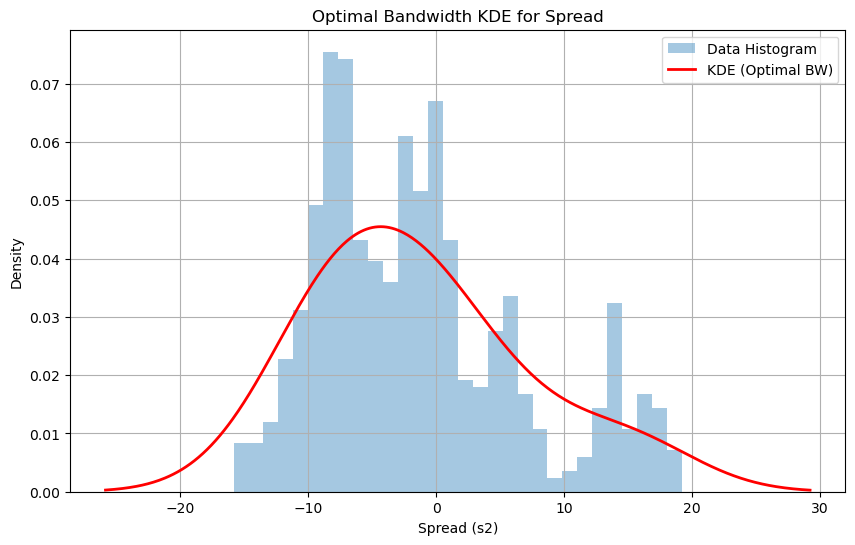

In [70]:
data_reshaped = data.reshape(-1, 1)
bandwidths = np.linspace(0.5, 5.0, 10)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(data_reshaped)

best_bw = grid.best_params_['bandwidth']
print(f"Optimal KDE Bandwidth = {best_bw:.2f}")

kde = KernelDensity(kernel='gaussian', bandwidth=best_bw).fit(data_reshaped)

x_grid = np.linspace(data.min()-10, data.max()+10, 500)
log_dens = kde.score_samples(x_grid.reshape(-1,1))
pdf_kde = np.exp(log_dens)

plt.figure(figsize=(10,6))
plt.hist(data, density=True, alpha=0.4, bins=30, label='Data Histogram')
plt.plot(x_grid, pdf_kde, 'r-', lw=2, label='KDE (Optimal BW)')
plt.title("Optimal Bandwidth KDE for Spread")
plt.xlabel("Spread (s2)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [71]:
N_BOOT = 1000
boot_means = []
boot_skews = []
boot_q05 = []
boot_q95 = []

n = len(data)
for _ in range(N_BOOT):
    sample = np.random.choice(data, size=n, replace=True)
    boot_means.append(np.mean(sample))
    boot_skews.append(stats.skew(sample))
    boot_q05.append(np.quantile(sample, 0.05))
    boot_q95.append(np.quantile(sample, 0.95))

boot_means = np.array(boot_means)
boot_skews = np.array(boot_skews)
boot_q05 = np.array(boot_q05)
boot_q95 = np.array(boot_q95)

mean_ci = (np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5))
skew_ci = (np.percentile(boot_skews, 2.5), np.percentile(boot_skews, 97.5))
q05_ci  = (np.percentile(boot_q05, 2.5), np.percentile(boot_q05, 97.5))
q95_ci  = (np.percentile(boot_q95, 2.5), np.percentile(boot_q95, 97.5))

print("\n--- Bootstrap Confidence Intervals ---")
print(f"Mean 95% CI: {mean_ci}")
print(f"Skewness 95% CI: {skew_ci}")
print(f"5% Quantile 95% CI: {q05_ci}")
print(f"95% Quantile 95% CI: {q95_ci}")


--- Bootstrap Confidence Intervals ---
Mean 95% CI: (-1.9118302006526653, -0.7514965328894582)
Skewness 95% CI: (0.6423704944361914, 0.8650767893236998)
5% Quantile 95% CI: (-12.23064875, -10.965196164832948)
95% Quantile 95% CI: (14.128636963947386, 16.50179565389)


In [72]:
threshold = np.percentile(data, 5) 
exceedances = data[data < threshold]
exceedances

array([-11.7077875 , -12.28816743, -13.58372942, -13.10677245,
       -13.233459  , -13.87099347, -12.88614236, -12.819337  ,
       -11.7400858 , -13.13569155, -12.12958271, -13.15492157,
       -14.00955916, -14.58855227, -15.82583697, -15.45551348,
       -14.34702411, -14.24532768, -15.56473125, -14.41454884,
       -14.75780003, -14.88530223, -14.70572982, -14.67901875,
       -12.98591875, -12.3763    , -13.0730875 , -11.93306875,
       -12.50371875, -12.089275  , -12.2192    , -11.68605   ,
       -11.62928125, -12.2573625 , -11.8102    , -11.72861875])

In [73]:
excess = -(exceedances - threshold)
shape, loc, scale = genpareto.fit(excess, loc=0)
print("\n--- GPD Fit (Negative Tail) ---")
print(f"Threshold: {threshold:.4f}")
print(f"Shape: {shape:.4f}, Loc: {loc:.4f}, Scale: {scale:.4f}")

ll_gpd = np.sum(genpareto.logpdf(excess, shape, loc=loc, scale=scale))
aic_gpd = 2*2 - 2*ll_gpd 
print(f"GPD Log-Likelihood: {ll_gpd:.2f}")
print(f"GPD AIC: {aic_gpd:.2f}")


--- GPD Fit (Negative Tail) ---
Threshold: -11.5860
Shape: -0.6446, Loc: 0.0433, Scale: 2.8183
GPD Log-Likelihood: -50.10
GPD AIC: 104.19


In [74]:
var_95, es_95 = gpd_var_es(prob=0.95, threshold=threshold, shape=shape, scale=scale)
print(f"95% VaR (negative tail) ~ {var_95:.2f}")
print(f"95% Expected Shortfall (negative tail) ~ {es_95:.2f}")

95% VaR (negative tail) ~ -15.32
95% Expected Shortfall (negative tail) ~ -9.21


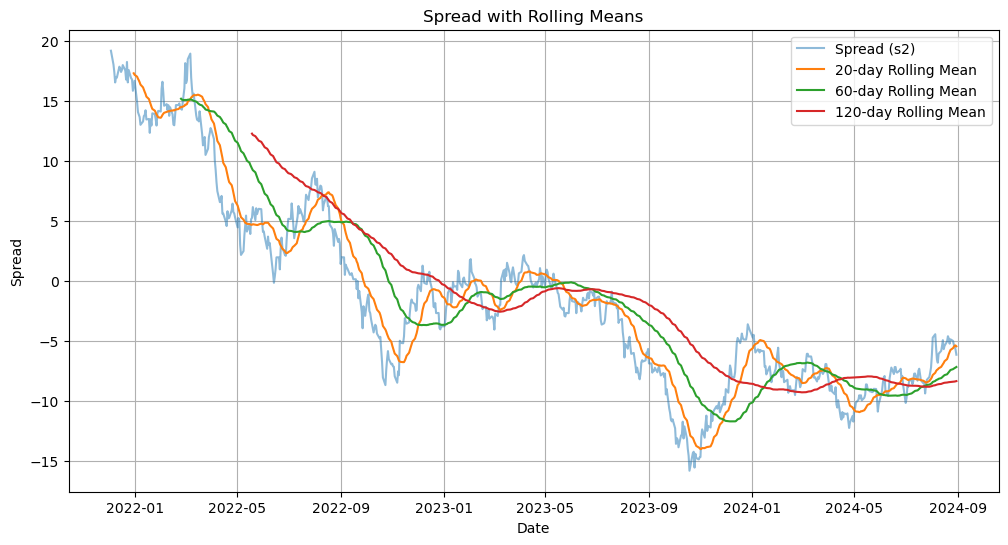

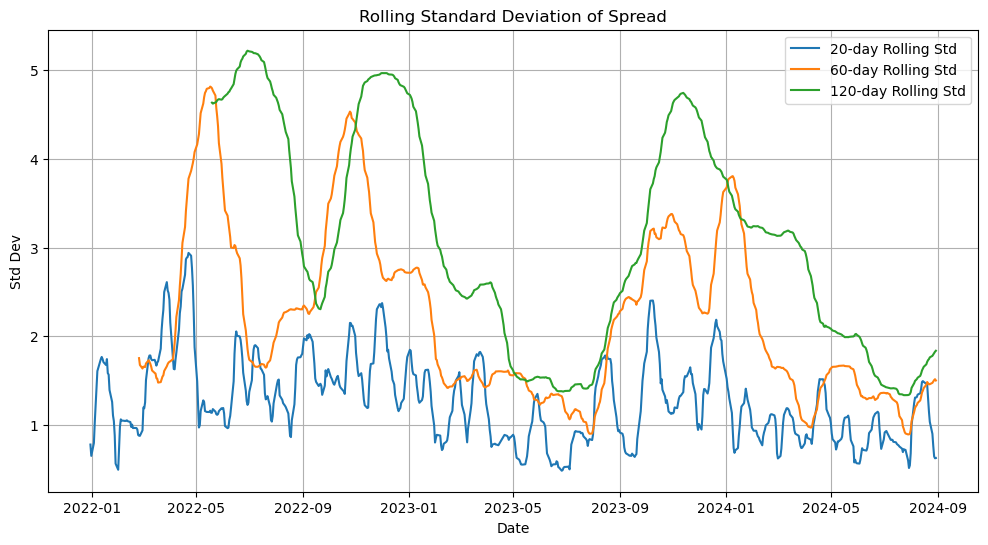

In [75]:
df = df_pair2.copy()
window_sizes = [20, 60, 120]  

for w in window_sizes:
    df[f'roll_mean_{w}'] = df['s2'].rolling(w).mean()
    df[f'roll_std_{w}']  = df['s2'].rolling(w).std()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['s2'], label='Spread (s2)', alpha=0.5)
for w in window_sizes:
    plt.plot(df.index, df[f'roll_mean_{w}'], label=f'{w}-day Rolling Mean')
plt.title("Spread with Rolling Means")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
for w in window_sizes:
    plt.plot(df.index, df[f'roll_std_{w}'], label=f'{w}-day Rolling Std')
plt.title("Rolling Standard Deviation of Spread")
plt.xlabel("Date")
plt.ylabel("Std Dev")
plt.legend()
plt.grid(True)
plt.show()

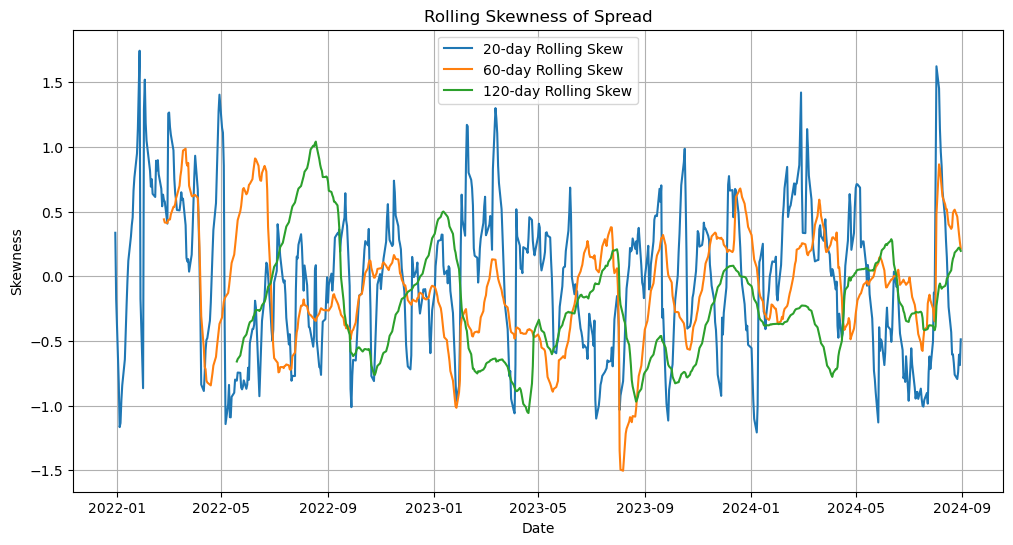

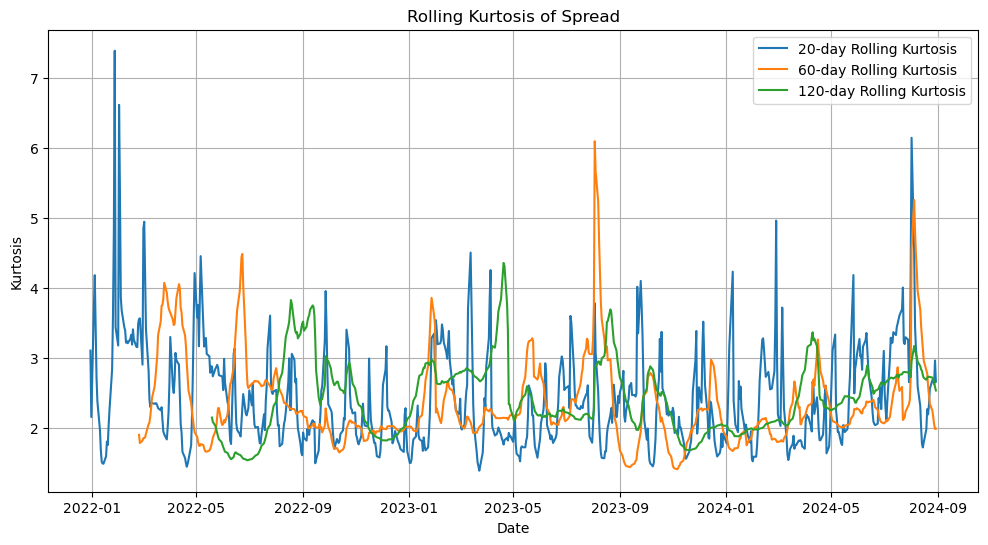

In [76]:
for w in window_sizes:
    df[f'roll_skew_{w}'] = df['s2'].rolling(w).apply(lambda x: skew(x.dropna()), raw=False)
    df[f'roll_kurt_{w}'] = df['s2'].rolling(w).apply(lambda x: kurtosis(x.dropna(), fisher=False), raw=False)

plt.figure(figsize=(12,6))
plt.plot(df.index, df['roll_skew_20'], label='20-day Rolling Skew')
plt.plot(df.index, df['roll_skew_60'], label='60-day Rolling Skew')
plt.plot(df.index, df['roll_skew_120'], label='120-day Rolling Skew')
plt.title("Rolling Skewness of Spread")
plt.xlabel("Date")
plt.ylabel("Skewness")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['roll_kurt_20'], label='20-day Rolling Kurtosis')
plt.plot(df.index, df['roll_kurt_60'], label='60-day Rolling Kurtosis')
plt.plot(df.index, df['roll_kurt_120'], label='120-day Rolling Kurtosis')
plt.title("Rolling Kurtosis of Spread")
plt.xlabel("Date")
plt.ylabel("Kurtosis")
plt.legend()
plt.grid(True)
plt.show()

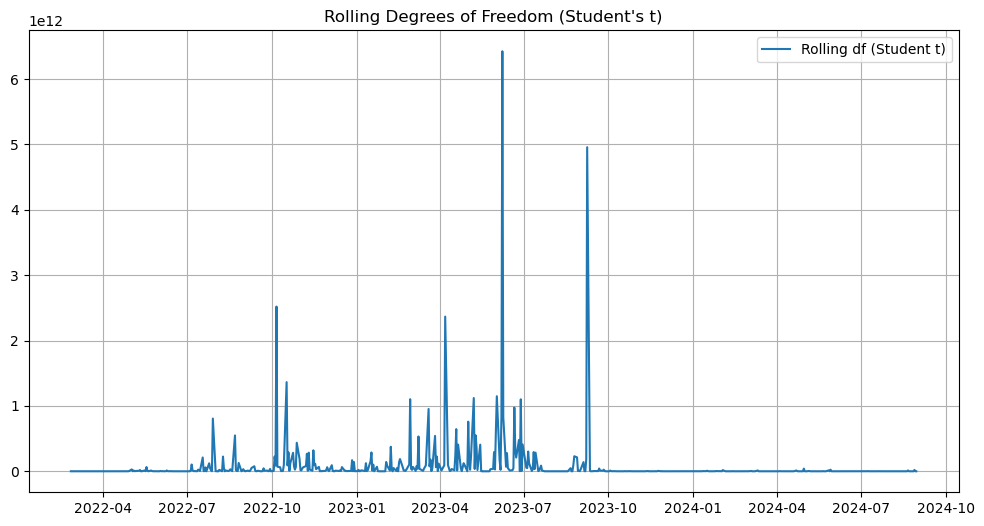

In [77]:
window = 60  
df['df_t'] = np.nan
df['loc_t'] = np.nan
df['scale_t'] = np.nan

for i in range(window, len(df)):
    sample = df['s2'].iloc[i-window:i].dropna().values
    if len(sample) > 0:
        df_val, loc_val, scale_val = t.fit(sample)
        df.loc[df.index[i], 'df_t'] = df_val
        df.loc[df.index[i], 'loc_t'] = loc_val
        df.loc[df.index[i], 'scale_t'] = scale_val

plt.figure(figsize=(12,6))
plt.plot(df.index, df['df_t'], label='Rolling df (Student t)')
plt.title("Rolling Degrees of Freedom (Student's t)")
plt.grid(True)
plt.legend()
plt.show()

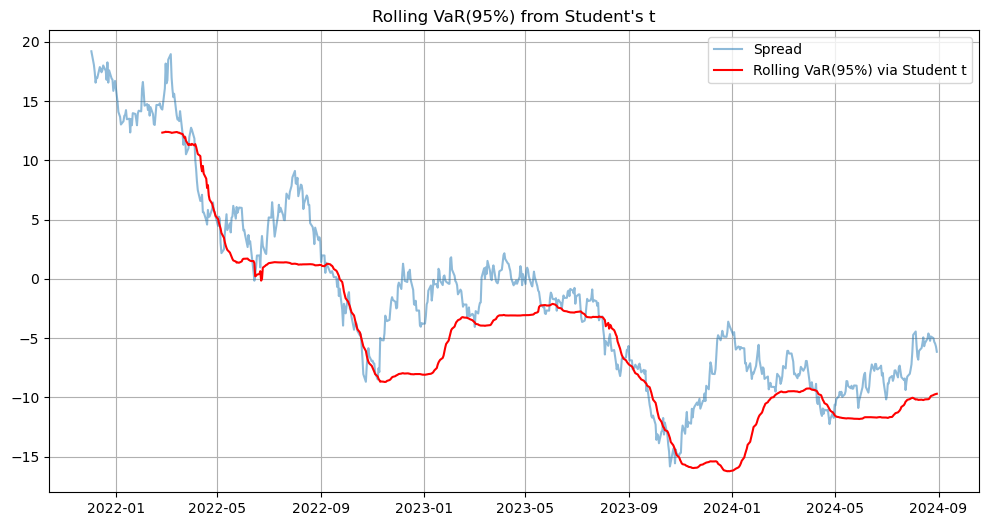

In [78]:
window = 60
df['var_95_t'] = np.nan
for i in range(window, len(df)):
    sample = df['s2'].iloc[i-window:i].dropna().values
    if len(sample) > 0:
        df.loc[df.index[i], 'var_95_t'] = student_t_var(sample, alpha=0.95)

plt.figure(figsize=(12,6))
plt.plot(df.index, df['s2'], alpha=0.5, label='Spread')
plt.plot(df.index, df['var_95_t'], color='red', label='Rolling VaR(95%) via Student t')
plt.title("Rolling VaR(95%) from Student's t")
plt.legend()
plt.grid(True)
plt.show()

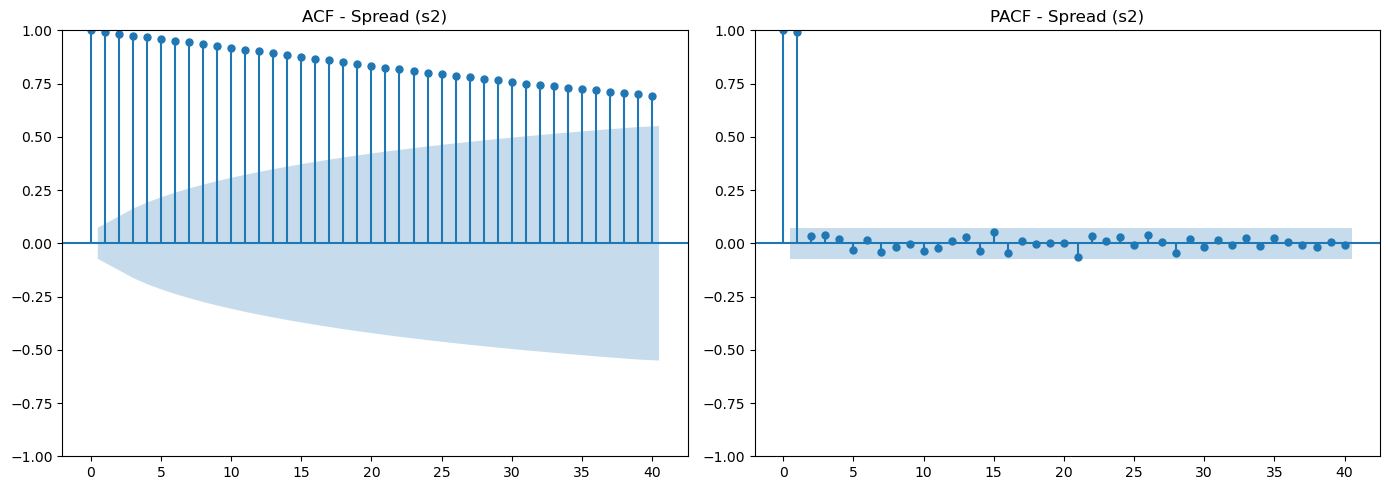

In [79]:
df_spread = df_pair2[['s2']].dropna()

lags = 40 
acf_vals = acf(df_spread['s2'], nlags=lags, fft=False)     
pacf_vals = pacf(df_spread['s2'], nlags=lags, method='ols')

fig, ax = plt.subplots(1,2, figsize=(14,5))
sm.graphics.tsa.plot_acf(df_spread['s2'], lags=lags, ax=ax[0], title="ACF - Spread (s2)")
sm.graphics.tsa.plot_pacf(df_spread['s2'], lags=lags, ax=ax[1], title="PACF - Spread (s2)")
plt.tight_layout()
plt.show()

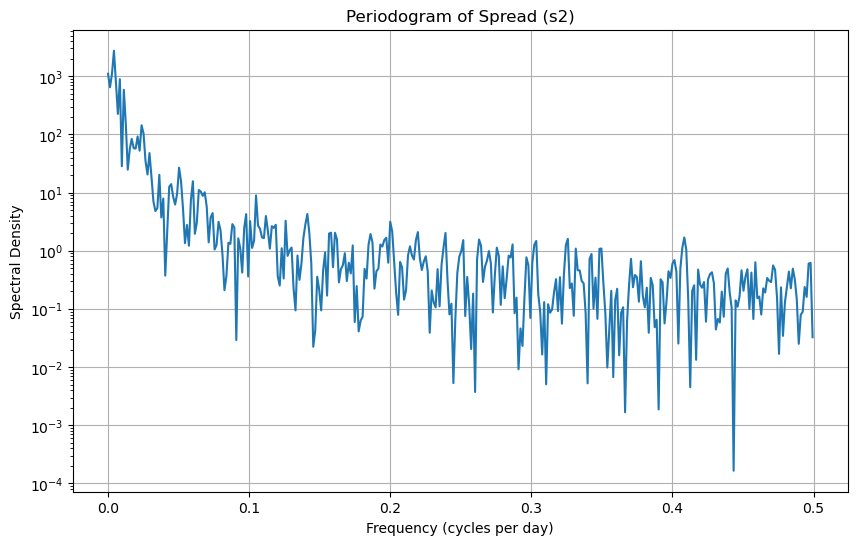

In [80]:
data = df_spread['s2'].values
fs = 1.0 

freqs, pxx = periodogram(data, fs=fs, window='hann', detrend='linear', scaling='density')

plt.figure(figsize=(10,6))
plt.semilogy(freqs, pxx)  # semilog-y is typical for spectral plots
plt.title("Periodogram of Spread (s2)")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Spectral Density")
plt.grid(True)
plt.show()

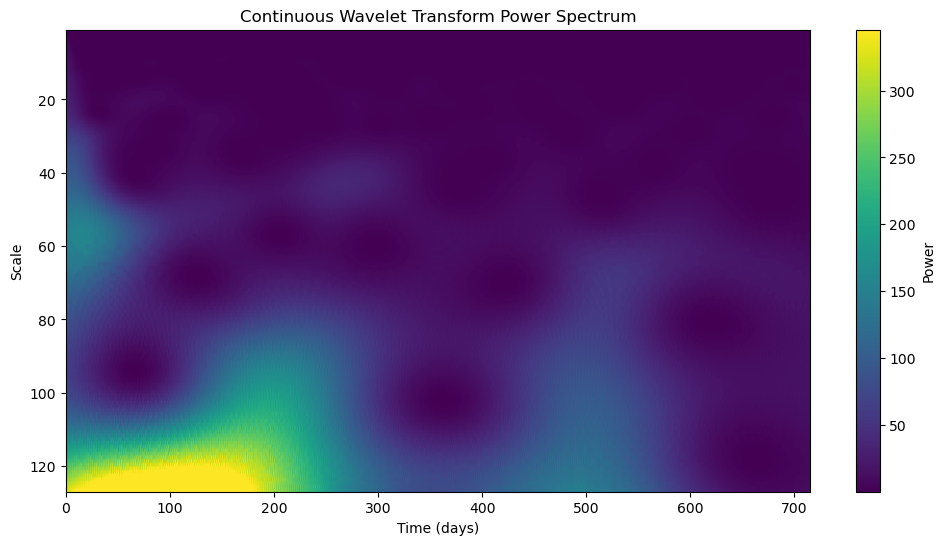

In [81]:
data = df_spread['s2'].values
dt = 1.0 
wavelet = 'cmor1.5-1.0'
scales = np.arange(1,128) 

coeffs, freqs = pywt.cwt(data, scales, wavelet, dt)
power = (np.abs(coeffs))**2

plt.figure(figsize=(12,6))
plt.imshow(power, extent=[0, len(data)*dt, scales[-1], scales[0]], cmap='viridis', aspect='auto',
           vmax=np.percentile(power, 99))
plt.colorbar(label='Power')
plt.title("Continuous Wavelet Transform Power Spectrum")
plt.xlabel("Time (days)")
plt.ylabel("Scale")
plt.show()

Breakpoints (end of segments): [90, 195, 435, 470, 520, 715]


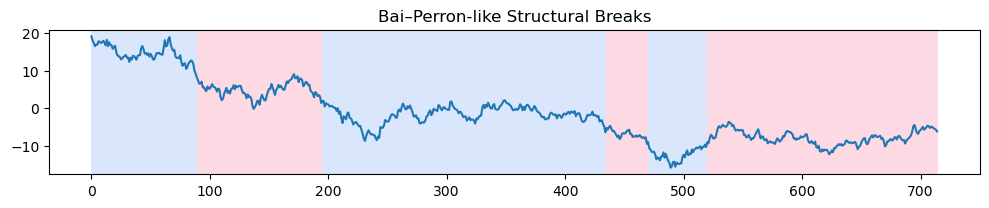

In [82]:
series = df_pair2['s2'].values
algo = rpt.Binseg(model="l2").fit(series)
breakpoints = algo.predict(n_bkps=5) 

print("Breakpoints (end of segments):", breakpoints)

rpt.display(series, breakpoints)
plt.title("Bai–Perron-like Structural Breaks")
plt.show()

Means of each state: [[ 0.07515471]
 [-0.71250826]]
Variances of each state: [[[0.47543461]]

 [[0.37427278]]]


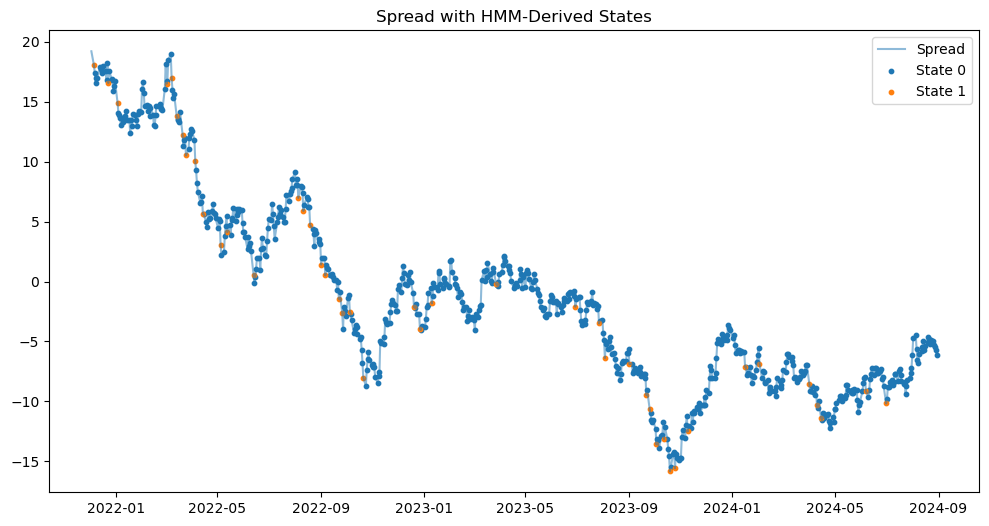

In [83]:
returns = df_pair2['s2'].diff().dropna().values.reshape(-1,1)
num_states = 2 
model = GaussianHMM(n_components=num_states, covariance_type="full", n_iter=100, random_state=42)
model.fit(returns)

states = model.predict(returns)
df_pair2.loc[df_pair2.index[1:], 'HMM_State'] = states  

print("Means of each state:", model.means_)
print("Variances of each state:", model.covars_)

plt.figure(figsize=(12,6))
plt.plot(df_pair2.index, df_pair2['s2'], alpha=0.5, label='Spread')
for i in range(num_states):
    mask = (df_pair2['HMM_State'] == i)
    plt.scatter(df_pair2.index[mask], df_pair2['s2'][mask], label=f"State {i}", s=10)
plt.title("Spread with HMM-Derived States")
plt.legend()
plt.show()

In [84]:
p, d, q = 1, 0, 1 
s2_series = df_pair2['s2'].dropna()
model = ARIMA(s2_series, order=(p, d, q))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                     s2   No. Observations:                  715
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -794.798
Date:                Wed, 15 Jan 2025   AIC                           1597.595
Time:                        07:49:00   BIC                           1615.884
Sample:                             0   HQIC                          1604.658
                                - 715                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0566      6.908      0.442      0.658     -10.482      16.595
ar.L1          0.9978      0.003    394.902      0.000       0.993       1.003
ma.L1         -0.0188      0.037     -0.509      0.6

Iteration:      5,   Func. Count:     30,   Neg. LLF: 802.6525228811491
Iteration:     10,   Func. Count:     55,   Neg. LLF: 802.4014785310782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 802.4014785310782
            Iterations: 11
            Function evaluations: 59
            Gradient evaluations: 11
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -802.401
Distribution:      Standardized Student's t   AIC:                           1612.80
Method:                  Maximum Likelihood   BIC:                           1631.09
                                              No. Observations:                  715
Date:                      Wed, Jan 15 2025   Df Res

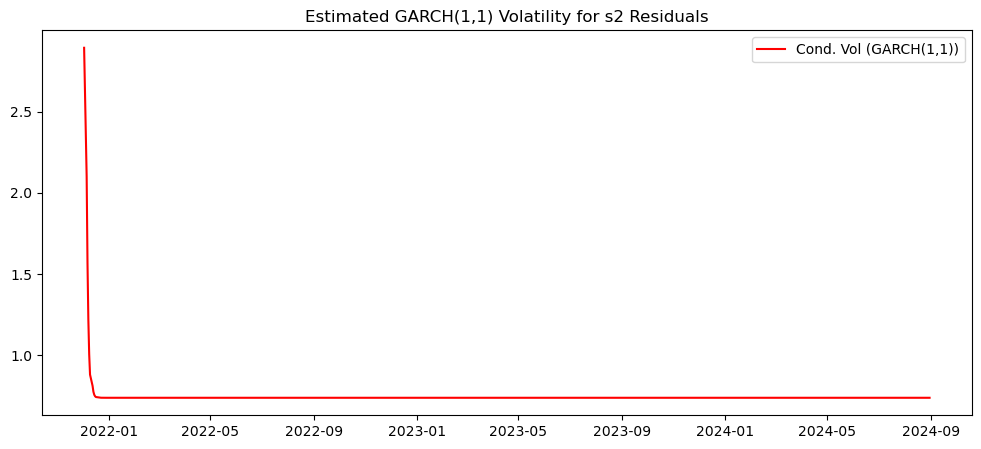

In [85]:
resid_for_garch = results.resid if 'results' in locals() else s2_series

garch_model = arch_model(resid_for_garch, p=1, q=1, mean='Zero', vol='GARCH', dist='t')
garch_res = garch_model.fit(update_freq=5)
print(garch_res.summary())

cond_vol = garch_res.conditional_volatility

plt.figure(figsize=(12,5))
plt.plot(cond_vol, color='red', label='Cond. Vol (GARCH(1,1))')
plt.title("Estimated GARCH(1,1) Volatility for s2 Residuals")
plt.legend()
plt.show()